In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, Dropout, Flatten, Dense
from keras.layers import GlobalMaxPooling2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_FILE = 'data/train_data.h5'
VAL_DATA_FILE = 'data/val_data.h5'
TEST_DATA_FILE = 'data/test_data.h5'
METADATA = 'metadata.npy'

metadata = np.load(METADATA).item()

VALIDATION AND TEST DATASET

In [3]:
val_f = h5py.File(VAL_DATA_FILE, 'r')

X_val = np.asarray(val_f['x'])
y_val = np.asarray(val_f['y'])

test_f = h5py.File(TEST_DATA_FILE, 'r')

X_test = np.asarray(test_f['x'])
y_test = np.asarray(test_f['y'])

METRICS

In [4]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    recall = recall(y_true, y_pred)
    precision = precision(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

In [5]:
import pandas as pd

results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

In [6]:
train_f = h5py.File(DATA_FILE, 'r')

train_data_x = train_f['x']
train_data_y = train_f['y']

X_train = np.asarray(train_data_x)
y_train = np.asarray(train_data_y)

In [7]:
lr = 0.05
n_conv_layers = 3
n_kernels = [128] * n_conv_layers
mp_sizes = [(2,2) for _ in range(n_conv_layers)]

model = Sequential()
model.add(BatchNormalization(axis=3, input_shape=train_data_x.shape[1:]))
for i in range(n_conv_layers):
    model.add(Conv2D(n_kernels[i], 3, 3, init='he_uniform', border_mode='same'))
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    if i < n_conv_layers - 1:
        model.add(MaxPooling2D(mp_sizes[i]))
        model.add(Dropout(0.5))

model.add(Conv2D(8,3,3, border_mode='same'))
model.add(GlobalMaxPooling2D())
model.add(Activation('softmax'))
model.compile(Adam(lr), loss='categorical_crossentropy', metrics=['accuracy', recall, precision, f1])
model.summary()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_initializer="he_uniform", padding="same")`
  if __name__ == '__main__':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 4, 7, 512)         2048      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 7, 128)         589952    
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 7, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, 4, 7, 128)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 3, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 3, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 3, 128)         147584    
__________

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), padding="same")`
  app.launch_new_instance()


In [8]:
model_filepath = 'models/Model.h5'
callbacks = [ModelCheckpoint(model_filepath, monitor='val_f1', verbose=1, save_best_only=True, mode="max")]
model.fit(X_train, y_train, batch_size=128, nb_epoch=10,
          validation_data=(X_val, y_val), callbacks=callbacks)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 9133 samples, validate on 370 samples
Epoch 1/10


 128/9133 [..............................] - ETA: 169s - loss: 2.1420 - acc: 0.0547 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1: nan

 256/9133 [..............................] - ETA: 103s - loss: 2.2940 - acc: 0.1953 - recall: 0.1484 - precision: 0.1652 - f1: nan        

 384/9133 [>.............................] - ETA: 79s - loss: 2.2878 - acc: 0.2760 - recall: 0.2223 - precision: 0.2579 - f1: nan 

 512/9133 [>.............................] - ETA: 68s - loss: 2.2759 - acc: 0.3223 - recall: 0.2351 - precision: 0.3260 - f1: nan

 640/9133 [=>............................] - ETA: 60s - loss: 2.2159 - acc: 0.3312 - recall: 0.2053 - precision: 0.3237 - f1: nan

 768/9133 [=>............................] - ETA: 56s - loss: 2.1640 - acc: 0.3268 - recall: 0.1737 - precision: 0.3031 - f1: nan

 896/9133 [=>............................] - ETA: 52s - loss: 2.0989 - acc: 0.3270 - recall: 0.1544 - precision: 0.3193 - f1: nan

1024/9133 [==>...........................] - ETA: 50s - loss: 2.0362 - acc: 0.3477 - recall: 0.1498 - precision: 0.3687 - f1: nan

1152/9133 [==>...........................] - ETA: 47s - loss: 1.9840 - acc: 0.3602 - recall: 0.1585 - precision: 0.3993 - f1: nan

1280/9133 [===>..........................] - ETA: 45s - loss: 1.9443 - acc: 0.3695 - recall: 0.1591 - precision: 0.4146 - f1: nan

1408/9133 [===>..........................] - ETA: 43s - loss: 1.9063 - acc: 0.3764 - recall: 0.1631 - precision: 0.4346 - f1: nan

1536/9133 [====>.........................] - ETA: 41s - loss: 1.8754 - acc: 0.3822 - recall: 0.1697 - precision: 0.4585 - f1: nan

1664/9133 [====>.........................] - ETA: 40s - loss: 1.8633 - acc: 0.3930 - recall: 0.1722 - precision: 0.4697 - f1: nan

1792/9133 [====>.........................] - ETA: 38s - loss: 1.8332 - acc: 0.3956 - recall: 0.1750 - precision: 0.4883 - f1: nan

1920/9133 [=====>........................] - ETA: 37s - loss: 1.8094 - acc: 0.4031 - recall: 0.1759 - precision: 0.5002 - f1: nan

2048/9133 [=====>........................] - ETA: 36s - loss: 1.7879 - acc: 0.4160 - recall: 0.1796 - precision: 0.5072 - f1: nan

2176/9133 [======>.......................] - ETA: 35s - loss: 1.7635 - acc: 0.4200 - recall: 0.1814 - precision: 0.5215 - f1: nan

2304/9133 [======>.......................] - ETA: 34s - loss: 1.7426 - acc: 0.4219 - recall: 0.1831 - precision: 0.5310 - f1: nan

2432/9133 [======>.......................] - ETA: 33s - loss: 1.7263 - acc: 0.4235 - recall: 0.1829 - precision: 0.5434 - f1: nan

2560/9133 [=======>......................] - ETA: 32s - loss: 1.7065 - acc: 0.4273 - recall: 0.1859 - precision: 0.5559 - f1: nan

2688/9133 [=======>......................] - ETA: 31s - loss: 1.6837 - acc: 0.4289 - recall: 0.1874 - precision: 0.5636 - f1: nan

2816/9133 [========>.....................] - ETA: 30s - loss: 1.6686 - acc: 0.4343 - recall: 0.1917 - precision: 0.5672 - f1: nan

2944/9133 [========>.....................] - ETA: 30s - loss: 1.6604 - acc: 0.4385 - recall: 0.1976 - precision: 0.5764 - f1: nan

3072/9133 [=========>....................] - ETA: 29s - loss: 1.6503 - acc: 0.4404 - recall: 0.2040 - precision: 0.5771 - f1: nan

3200/9133 [=========>....................] - ETA: 28s - loss: 1.6320 - acc: 0.4447 - recall: 0.2115 - precision: 0.5825 - f1: nan

3328/9133 [=========>....................] - ETA: 27s - loss: 1.6266 - acc: 0.4453 - recall: 0.2175 - precision: 0.5827 - f1: nan

3456/9133 [==========>...................] - ETA: 26s - loss: 1.6154 - acc: 0.4473 - recall: 0.2239 - precision: 0.5858 - f1: nan

3584/9133 [==========>...................] - ETA: 26s - loss: 1.6100 - acc: 0.4506 - recall: 0.2279 - precision: 0.5872 - f1: nan

3712/9133 [===========>..................] - ETA: 25s - loss: 1.5960 - acc: 0.4550 - recall: 0.2339 - precision: 0.5948 - f1: nan

3840/9133 [===========>..................] - ETA: 24s - loss: 1.5879 - acc: 0.4570 - recall: 0.2362 - precision: 0.5978 - f1: nan

3968/9133 [============>.................] - ETA: 24s - loss: 1.5812 - acc: 0.4567 - recall: 0.2362 - precision: 0.6000 - f1: nan

4096/9133 [============>.................] - ETA: 23s - loss: 1.5695 - acc: 0.4587 - recall: 0.2381 - precision: 0.6071 - f1: nan

4224/9133 [============>.................] - ETA: 22s - loss: 1.5599 - acc: 0.4624 - recall: 0.2401 - precision: 0.6150 - f1: nan

4352/9133 [=============>................] - ETA: 22s - loss: 1.5475 - acc: 0.4658 - recall: 0.2438 - precision: 0.6199 - f1: nan

4480/9133 [=============>................] - ETA: 21s - loss: 1.5349 - acc: 0.4690 - recall: 0.2460 - precision: 0.6266 - f1: nan

4608/9133 [==============>...............] - ETA: 20s - loss: 1.5266 - acc: 0.4707 - recall: 0.2492 - precision: 0.6289 - f1: nan

4736/9133 [==============>...............] - ETA: 20s - loss: 1.5231 - acc: 0.4711 - recall: 0.2524 - precision: 0.6293 - f1: nan

4864/9133 [==============>...............] - ETA: 19s - loss: 1.5170 - acc: 0.4722 - recall: 0.2560 - precision: 0.6294 - f1: nan

4992/9133 [===============>..............] - ETA: 18s - loss: 1.5055 - acc: 0.4758 - recall: 0.2607 - precision: 0.6332 - f1: nan

5120/9133 [===============>..............] - ETA: 18s - loss: 1.5010 - acc: 0.4766 - recall: 0.2632 - precision: 0.6338 - f1: nan

5248/9133 [================>.............] - ETA: 17s - loss: 1.4968 - acc: 0.4788 - recall: 0.2661 - precision: 0.6354 - f1: nan

5376/9133 [================>.............] - ETA: 17s - loss: 1.4870 - acc: 0.4823 - recall: 0.2700 - precision: 0.6401 - f1: nan

5504/9133 [=================>............] - ETA: 16s - loss: 1.4788 - acc: 0.4856 - recall: 0.2741 - precision: 0.6434 - f1: nan

5632/9133 [=================>............] - ETA: 15s - loss: 1.4736 - acc: 0.4862 - recall: 0.2771 - precision: 0.6454 - f1: nan

5760/9133 [=================>............] - ETA: 15s - loss: 1.4704 - acc: 0.4866 - recall: 0.2793 - precision: 0.6457 - f1: nan

5888/9133 [==================>...........] - ETA: 14s - loss: 1.4676 - acc: 0.4878 - recall: 0.2807 - precision: 0.6468 - f1: nan

6016/9133 [==================>...........] - ETA: 13s - loss: 1.4599 - acc: 0.4899 - recall: 0.2829 - precision: 0.6484 - f1: nan

6144/9133 [===================>..........] - ETA: 13s - loss: 1.4529 - acc: 0.4917 - recall: 0.2855 - precision: 0.6506 - f1: nan

6272/9133 [===================>..........] - ETA: 12s - loss: 1.4462 - acc: 0.4941 - recall: 0.2881 - precision: 0.6532 - f1: nan

6400/9133 [====================>.........] - ETA: 12s - loss: 1.4385 - acc: 0.4964 - recall: 0.2911 - precision: 0.6543 - f1: nan

6528/9133 [====================>.........] - ETA: 11s - loss: 1.4327 - acc: 0.4975 - recall: 0.2941 - precision: 0.6575 - f1: nan

6656/9133 [====================>.........] - ETA: 11s - loss: 1.4251 - acc: 0.5000 - recall: 0.2969 - precision: 0.6594 - f1: nan

6784/9133 [=====================>........] - ETA: 10s - loss: 1.4188 - acc: 0.5009 - recall: 0.2997 - precision: 0.6600 - f1: nan

6912/9133 [=====================>........] - ETA: 9s - loss: 1.4120 - acc: 0.5030 - recall: 0.3028 - precision: 0.6626 - f1: nan 

7040/9133 [======================>.......] - ETA: 9s - loss: 1.4100 - acc: 0.5048 - recall: 0.3053 - precision: 0.6651 - f1: nan

7168/9133 [======================>.......] - ETA: 8s - loss: 1.4070 - acc: 0.5057 - recall: 0.3078 - precision: 0.6665 - f1: nan

7296/9133 [======================>.......] - ETA: 8s - loss: 1.4011 - acc: 0.5074 - recall: 0.3113 - precision: 0.6684 - f1: nan

7424/9133 [=======================>......] - ETA: 7s - loss: 1.3947 - acc: 0.5104 - recall: 0.3153 - precision: 0.6704 - f1: nan

7552/9133 [=======================>......] - ETA: 6s - loss: 1.3890 - acc: 0.5131 - recall: 0.3185 - precision: 0.6719 - f1: nan

7680/9133 [========================>.....] - ETA: 6s - loss: 1.3838 - acc: 0.5151 - recall: 0.3210 - precision: 0.6721 - f1: nan

7808/9133 [========================>.....] - ETA: 5s - loss: 1.3768 - acc: 0.5175 - recall: 0.3243 - precision: 0.6752 - f1: nan

7936/9133 [=========================>....] - ETA: 5s - loss: 1.3699 - acc: 0.5198 - recall: 0.3280 - precision: 0.6776 - f1: nan

8064/9133 [=========================>....] - ETA: 4s - loss: 1.3614 - acc: 0.5229 - recall: 0.3317 - precision: 0.6801 - f1: nan

8192/9133 [=========================>....] - ETA: 4s - loss: 1.3545 - acc: 0.5255 - recall: 0.3359 - precision: 0.6823 - f1: nan

8320/9133 [==========================>...] - ETA: 3s - loss: 1.3486 - acc: 0.5276 - recall: 0.3394 - precision: 0.6835 - f1: nan

8448/9133 [==========================>...] - ETA: 2s - loss: 1.3451 - acc: 0.5289 - recall: 0.3419 - precision: 0.6841 - f1: nan

8576/9133 [===========================>..] - ETA: 2s - loss: 1.3410 - acc: 0.5304 - recall: 0.3443 - precision: 0.6844 - f1: nan

8704/9133 [===========================>..] - ETA: 1s - loss: 1.3333 - acc: 0.5325 - recall: 0.3483 - precision: 0.6863 - f1: nan

8832/9133 [============================>.] - ETA: 1s - loss: 1.3291 - acc: 0.5342 - recall: 0.3513 - precision: 0.6878 - f1: nan

8960/9133 [============================>.] - ETA: 0s - loss: 1.3262 - acc: 0.5347 - recall: 0.3532 - precision: 0.6891 - f1: nan

9088/9133 [============================>.] - ETA: 0s - loss: 1.3227 - acc: 0.5357 - recall: 0.3549 - precision: 0.6898 - f1: nan

Epoch 00000: val_f1 improved from -inf to 0.68909, saving model to models/Model.h5
9133/9133 [==============================] - 40s - loss: 1.3210 - acc: 0.5360 - recall: 0.3557 - precision: 0.6901 - f1: nan - val_loss: 3.1785 - val_acc: 0.6892 - val_recall: 0.6892 - val_precision: 0.6890 - val_f1: 0.6891


Epoch 2/10


 128/9133 [..............................] - ETA: 39s - loss: 0.9555 - acc: 0.6562 - recall: 0.5469 - precision: 0.8235 - f1: 0.6573

 256/9133 [..............................] - ETA: 38s - loss: 0.9603 - acc: 0.6562 - recall: 0.5312 - precision: 0.8403 - f1: 0.6506

 384/9133 [>.............................] - ETA: 37s - loss: 0.9308 - acc: 0.6771 - recall: 0.5469 - precision: 0.8504 - f1: 0.6653

 512/9133 [>.............................] - ETA: 37s - loss: 0.9401 - acc: 0.6699 - recall: 0.5391 - precision: 0.8319 - f1: 0.6539

 640/9133 [=>............................] - ETA: 36s - loss: 0.9411 - acc: 0.6656 - recall: 0.5375 - precision: 0.8334 - f1: 0.6533

 768/9133 [=>............................] - ETA: 35s - loss: 0.9270 - acc: 0.6732 - recall: 0.5469 - precision: 0.8385 - f1: 0.6617

 896/9133 [=>............................] - ETA: 34s - loss: 0.9301 - acc: 0.6730 - recall: 0.5480 - precision: 0.8394 - f1: 0.6629

1024/9133 [==>...........................] - ETA: 34s - loss: 0.8966 - acc: 0.6836 - recall: 0.5586 - precision: 0.8483 - f1: 0.6733

1152/9133 [==>...........................] - ETA: 33s - loss: 0.8749 - acc: 0.6910 - recall: 0.5686 - precision: 0.8491 - f1: 0.6805

1280/9133 [===>..........................] - ETA: 32s - loss: 0.8657 - acc: 0.6953 - recall: 0.5766 - precision: 0.8456 - f1: 0.6846

1408/9133 [===>..........................] - ETA: 32s - loss: 0.8564 - acc: 0.6989 - recall: 0.5850 - precision: 0.8460 - f1: 0.6904

1536/9133 [====>.........................] - ETA: 31s - loss: 0.8431 - acc: 0.7031 - recall: 0.5942 - precision: 0.8448 - f1: 0.6960

1664/9133 [====>.........................] - ETA: 31s - loss: 0.8473 - acc: 0.7001 - recall: 0.5948 - precision: 0.8379 - f1: 0.6940

1792/9133 [====>.........................] - ETA: 30s - loss: 0.8304 - acc: 0.7065 - recall: 0.6042 - precision: 0.8395 - f1: 0.7007

1920/9133 [=====>........................] - ETA: 30s - loss: 0.8435 - acc: 0.7036 - recall: 0.6030 - precision: 0.8316 - f1: 0.6971

2048/9133 [=====>........................] - ETA: 29s - loss: 0.8416 - acc: 0.7036 - recall: 0.6066 - precision: 0.8283 - f1: 0.6982

2176/9133 [======>.......................] - ETA: 29s - loss: 0.8476 - acc: 0.7027 - recall: 0.6081 - precision: 0.8249 - f1: 0.6980

2304/9133 [======>.......................] - ETA: 28s - loss: 0.8580 - acc: 0.6970 - recall: 0.6052 - precision: 0.8215 - f1: 0.6950

2432/9133 [======>.......................] - ETA: 27s - loss: 0.8632 - acc: 0.6965 - recall: 0.6046 - precision: 0.8199 - f1: 0.6941

2560/9133 [=======>......................] - ETA: 27s - loss: 0.8655 - acc: 0.6957 - recall: 0.6033 - precision: 0.8201 - f1: 0.6933

2688/9133 [=======>......................] - ETA: 26s - loss: 0.8639 - acc: 0.6949 - recall: 0.6024 - precision: 0.8211 - f1: 0.6932

2816/9133 [========>.....................] - ETA: 26s - loss: 0.8634 - acc: 0.6942 - recall: 0.5995 - precision: 0.8216 - f1: 0.6915

2944/9133 [========>.....................] - ETA: 25s - loss: 0.8583 - acc: 0.6970 - recall: 0.6010 - precision: 0.8226 - f1: 0.6928

3072/9133 [=========>....................] - ETA: 25s - loss: 0.8635 - acc: 0.6956 - recall: 0.5991 - precision: 0.8198 - f1: 0.6906

3200/9133 [=========>....................] - ETA: 24s - loss: 0.8636 - acc: 0.6969 - recall: 0.6000 - precision: 0.8195 - f1: 0.6912

3328/9133 [=========>....................] - ETA: 24s - loss: 0.8634 - acc: 0.6959 - recall: 0.5988 - precision: 0.8192 - f1: 0.6904

3456/9133 [==========>...................] - ETA: 23s - loss: 0.8616 - acc: 0.6959 - recall: 0.5992 - precision: 0.8193 - f1: 0.6907

3584/9133 [==========>...................] - ETA: 23s - loss: 0.8567 - acc: 0.6978 - recall: 0.6007 - precision: 0.8209 - f1: 0.6923

3712/9133 [===========>..................] - ETA: 22s - loss: 0.8482 - acc: 0.7007 - recall: 0.6021 - precision: 0.8233 - f1: 0.6942

3840/9133 [===========>..................] - ETA: 22s - loss: 0.8482 - acc: 0.6995 - recall: 0.6005 - precision: 0.8224 - f1: 0.6928

3968/9133 [============>.................] - ETA: 21s - loss: 0.8524 - acc: 0.6986 - recall: 0.5990 - precision: 0.8208 - f1: 0.6913

4096/9133 [============>.................] - ETA: 20s - loss: 0.8467 - acc: 0.7000 - recall: 0.6003 - precision: 0.8205 - f1: 0.6921

4224/9133 [============>.................] - ETA: 20s - loss: 0.8395 - acc: 0.7036 - recall: 0.6044 - precision: 0.8228 - f1: 0.6956

4352/9133 [=============>................] - ETA: 19s - loss: 0.8408 - acc: 0.7031 - recall: 0.6043 - precision: 0.8210 - f1: 0.6949

4480/9133 [=============>................] - ETA: 19s - loss: 0.8322 - acc: 0.7058 - recall: 0.6082 - precision: 0.8225 - f1: 0.6979

4608/9133 [==============>...............] - ETA: 18s - loss: 0.8366 - acc: 0.7051 - recall: 0.6081 - precision: 0.8200 - f1: 0.6969

4736/9133 [==============>...............] - ETA: 18s - loss: 0.8368 - acc: 0.7054 - recall: 0.6100 - precision: 0.8190 - f1: 0.6977

4864/9133 [==============>...............] - ETA: 17s - loss: 0.8306 - acc: 0.7076 - recall: 0.6127 - precision: 0.8194 - f1: 0.6996

4992/9133 [===============>..............] - ETA: 17s - loss: 0.8298 - acc: 0.7087 - recall: 0.6144 - precision: 0.8185 - f1: 0.7003

5120/9133 [===============>..............] - ETA: 16s - loss: 0.8307 - acc: 0.7084 - recall: 0.6139 - precision: 0.8183 - f1: 0.6999

5248/9133 [================>.............] - ETA: 16s - loss: 0.8264 - acc: 0.7119 - recall: 0.6166 - precision: 0.8197 - f1: 0.7022

5376/9133 [================>.............] - ETA: 15s - loss: 0.8242 - acc: 0.7128 - recall: 0.6174 - precision: 0.8197 - f1: 0.7028

5504/9133 [=================>............] - ETA: 15s - loss: 0.8252 - acc: 0.7128 - recall: 0.6181 - precision: 0.8191 - f1: 0.7030

5632/9133 [=================>............] - ETA: 14s - loss: 0.8216 - acc: 0.7134 - recall: 0.6200 - precision: 0.8201 - f1: 0.7047

5760/9133 [=================>............] - ETA: 14s - loss: 0.8181 - acc: 0.7155 - recall: 0.6217 - precision: 0.8211 - f1: 0.7061

5888/9133 [==================>...........] - ETA: 13s - loss: 0.8164 - acc: 0.7167 - recall: 0.6240 - precision: 0.8218 - f1: 0.7078

6016/9133 [==================>...........] - ETA: 13s - loss: 0.8156 - acc: 0.7168 - recall: 0.6242 - precision: 0.8215 - f1: 0.7079

6144/9133 [===================>..........] - ETA: 12s - loss: 0.8112 - acc: 0.7178 - recall: 0.6255 - precision: 0.8214 - f1: 0.7087

6272/9133 [===================>..........] - ETA: 11s - loss: 0.8095 - acc: 0.7180 - recall: 0.6264 - precision: 0.8207 - f1: 0.7090

6400/9133 [====================>.........] - ETA: 11s - loss: 0.8067 - acc: 0.7186 - recall: 0.6274 - precision: 0.8210 - f1: 0.7098

6528/9133 [====================>.........] - ETA: 10s - loss: 0.8056 - acc: 0.7195 - recall: 0.6286 - precision: 0.8206 - f1: 0.7104

6656/9133 [====================>.........] - ETA: 10s - loss: 0.8091 - acc: 0.7188 - recall: 0.6289 - precision: 0.8188 - f1: 0.7099

6784/9133 [=====================>........] - ETA: 9s - loss: 0.8046 - acc: 0.7201 - recall: 0.6308 - precision: 0.8189 - f1: 0.7110 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.8089 - acc: 0.7190 - recall: 0.6298 - precision: 0.8165 - f1: 0.7095

7040/9133 [======================>.......] - ETA: 8s - loss: 0.8067 - acc: 0.7200 - recall: 0.6309 - precision: 0.8169 - f1: 0.7104

7168/9133 [======================>.......] - ETA: 8s - loss: 0.8045 - acc: 0.7207 - recall: 0.6317 - precision: 0.8175 - f1: 0.7112

7296/9133 [======================>.......] - ETA: 7s - loss: 0.8003 - acc: 0.7220 - recall: 0.6338 - precision: 0.8194 - f1: 0.7132

7424/9133 [=======================>......] - ETA: 7s - loss: 0.7999 - acc: 0.7223 - recall: 0.6339 - precision: 0.8190 - f1: 0.7132

7552/9133 [=======================>......] - ETA: 6s - loss: 0.7969 - acc: 0.7233 - recall: 0.6350 - precision: 0.8191 - f1: 0.7139

7680/9133 [========================>.....] - ETA: 6s - loss: 0.7921 - acc: 0.7250 - recall: 0.6374 - precision: 0.8204 - f1: 0.7159

7808/9133 [========================>.....] - ETA: 5s - loss: 0.7919 - acc: 0.7252 - recall: 0.6382 - precision: 0.8205 - f1: 0.7165

7936/9133 [=========================>....] - ETA: 5s - loss: 0.7880 - acc: 0.7269 - recall: 0.6409 - precision: 0.8213 - f1: 0.7184

8064/9133 [=========================>....] - ETA: 4s - loss: 0.7855 - acc: 0.7281 - recall: 0.6425 - precision: 0.8214 - f1: 0.7194

8192/9133 [=========================>....] - ETA: 3s - loss: 0.7840 - acc: 0.7285 - recall: 0.6434 - precision: 0.8212 - f1: 0.7199

8320/9133 [==========================>...] - ETA: 3s - loss: 0.7826 - acc: 0.7292 - recall: 0.6446 - precision: 0.8214 - f1: 0.7207

8448/9133 [==========================>...] - ETA: 2s - loss: 0.7807 - acc: 0.7306 - recall: 0.6464 - precision: 0.8220 - f1: 0.7221

8576/9133 [===========================>..] - ETA: 2s - loss: 0.7774 - acc: 0.7312 - recall: 0.6476 - precision: 0.8218 - f1: 0.7227

8704/9133 [===========================>..] - ETA: 1s - loss: 0.7740 - acc: 0.7321 - recall: 0.6489 - precision: 0.8225 - f1: 0.7238

8832/9133 [============================>.] - ETA: 1s - loss: 0.7713 - acc: 0.7323 - recall: 0.6499 - precision: 0.8225 - f1: 0.7244

8960/9133 [============================>.] - ETA: 0s - loss: 0.7677 - acc: 0.7333 - recall: 0.6511 - precision: 0.8232 - f1: 0.7255

9088/9133 [============================>.] - ETA: 0s - loss: 0.7637 - acc: 0.7353 - recall: 0.6537 - precision: 0.8241 - f1: 0.7274

Epoch 00001: val_f1 improved from 0.68909 to 0.77799, saving model to models/Model.h5
9133/9133 [==============================] - 38s - loss: 0.7641 - acc: 0.7351 - recall: 0.6540 - precision: 0.8239 - f1: 0.7275 - val_loss: 1.1988 - val_acc: 0.7838 - val_recall: 0.7743 - val_precision: 0.7817 - val_f1: 0.7780


Epoch 3/10


 128/9133 [..............................] - ETA: 39s - loss: 0.4200 - acc: 0.8516 - recall: 0.8281 - precision: 0.9138 - f1: 0.8689

 256/9133 [..............................] - ETA: 37s - loss: 0.5176 - acc: 0.8281 - recall: 0.7969 - precision: 0.8793 - f1: 0.8361

 384/9133 [>.............................] - ETA: 36s - loss: 0.5047 - acc: 0.8333 - recall: 0.7969 - precision: 0.8743 - f1: 0.8338

 512/9133 [>.............................] - ETA: 36s - loss: 0.5024 - acc: 0.8398 - recall: 0.8086 - precision: 0.8846 - f1: 0.8449

 640/9133 [=>............................] - ETA: 35s - loss: 0.5121 - acc: 0.8297 - recall: 0.7953 - precision: 0.8804 - f1: 0.8356

 768/9133 [=>............................] - ETA: 35s - loss: 0.5074 - acc: 0.8307 - recall: 0.7904 - precision: 0.8808 - f1: 0.8330

 896/9133 [=>............................] - ETA: 34s - loss: 0.5393 - acc: 0.8225 - recall: 0.7757 - precision: 0.8759 - f1: 0.8224

1024/9133 [==>...........................] - ETA: 33s - loss: 0.5325 - acc: 0.8262 - recall: 0.7783 - precision: 0.8802 - f1: 0.8258

1152/9133 [==>...........................] - ETA: 33s - loss: 0.5350 - acc: 0.8238 - recall: 0.7786 - precision: 0.8758 - f1: 0.8240

1280/9133 [===>..........................] - ETA: 32s - loss: 0.5271 - acc: 0.8258 - recall: 0.7828 - precision: 0.8764 - f1: 0.8266

1408/9133 [===>..........................] - ETA: 32s - loss: 0.5169 - acc: 0.8317 - recall: 0.7869 - precision: 0.8798 - f1: 0.8305

1536/9133 [====>.........................] - ETA: 31s - loss: 0.5092 - acc: 0.8346 - recall: 0.7923 - precision: 0.8822 - f1: 0.8345

1664/9133 [====>.........................] - ETA: 31s - loss: 0.5021 - acc: 0.8383 - recall: 0.7951 - precision: 0.8859 - f1: 0.8377

1792/9133 [====>.........................] - ETA: 30s - loss: 0.5024 - acc: 0.8387 - recall: 0.7941 - precision: 0.8847 - f1: 0.8367

1920/9133 [=====>........................] - ETA: 30s - loss: 0.5061 - acc: 0.8359 - recall: 0.7921 - precision: 0.8815 - f1: 0.8341

2048/9133 [=====>........................] - ETA: 29s - loss: 0.5117 - acc: 0.8335 - recall: 0.7919 - precision: 0.8785 - f1: 0.8327

2176/9133 [======>.......................] - ETA: 29s - loss: 0.5083 - acc: 0.8350 - recall: 0.7922 - precision: 0.8786 - f1: 0.8329

2304/9133 [======>.......................] - ETA: 28s - loss: 0.5106 - acc: 0.8351 - recall: 0.7937 - precision: 0.8768 - f1: 0.8329

2432/9133 [======>.......................] - ETA: 28s - loss: 0.5126 - acc: 0.8351 - recall: 0.7943 - precision: 0.8755 - f1: 0.8326

2560/9133 [=======>......................] - ETA: 27s - loss: 0.5038 - acc: 0.8387 - recall: 0.7991 - precision: 0.8773 - f1: 0.8360

2688/9133 [=======>......................] - ETA: 26s - loss: 0.5050 - acc: 0.8378 - recall: 0.7986 - precision: 0.8756 - f1: 0.8350

2816/9133 [========>.....................] - ETA: 26s - loss: 0.4996 - acc: 0.8398 - recall: 0.8014 - precision: 0.8765 - f1: 0.8369

2944/9133 [========>.....................] - ETA: 25s - loss: 0.4983 - acc: 0.8397 - recall: 0.8016 - precision: 0.8751 - f1: 0.8363

3072/9133 [=========>....................] - ETA: 25s - loss: 0.4967 - acc: 0.8392 - recall: 0.8023 - precision: 0.8757 - f1: 0.8371

3200/9133 [=========>....................] - ETA: 24s - loss: 0.4894 - acc: 0.8413 - recall: 0.8037 - precision: 0.8772 - f1: 0.8385

3328/9133 [=========>....................] - ETA: 24s - loss: 0.4899 - acc: 0.8419 - recall: 0.8046 - precision: 0.8786 - f1: 0.8397

3456/9133 [==========>...................] - ETA: 23s - loss: 0.4958 - acc: 0.8394 - recall: 0.8032 - precision: 0.8758 - f1: 0.8376

3584/9133 [==========>...................] - ETA: 23s - loss: 0.4937 - acc: 0.8404 - recall: 0.8038 - precision: 0.8763 - f1: 0.8382

3712/9133 [===========>..................] - ETA: 22s - loss: 0.5004 - acc: 0.8381 - recall: 0.8019 - precision: 0.8759 - f1: 0.8370

3840/9133 [===========>..................] - ETA: 21s - loss: 0.5013 - acc: 0.8378 - recall: 0.8007 - precision: 0.8762 - f1: 0.8364

3968/9133 [============>.................] - ETA: 21s - loss: 0.5003 - acc: 0.8380 - recall: 0.8006 - precision: 0.8768 - f1: 0.8366

4096/9133 [============>.................] - ETA: 20s - loss: 0.5005 - acc: 0.8372 - recall: 0.7995 - precision: 0.8767 - f1: 0.8360

4224/9133 [============>.................] - ETA: 20s - loss: 0.5007 - acc: 0.8364 - recall: 0.7989 - precision: 0.8758 - f1: 0.8353

4352/9133 [=============>................] - ETA: 19s - loss: 0.4979 - acc: 0.8378 - recall: 0.8000 - precision: 0.8763 - f1: 0.8361

4480/9133 [=============>................] - ETA: 19s - loss: 0.4954 - acc: 0.8384 - recall: 0.8010 - precision: 0.8774 - f1: 0.8372

4608/9133 [==============>...............] - ETA: 18s - loss: 0.4954 - acc: 0.8388 - recall: 0.8011 - precision: 0.8781 - f1: 0.8376

4736/9133 [==============>...............] - ETA: 18s - loss: 0.4948 - acc: 0.8383 - recall: 0.8012 - precision: 0.8774 - f1: 0.8373

4864/9133 [==============>...............] - ETA: 17s - loss: 0.4946 - acc: 0.8374 - recall: 0.8007 - precision: 0.8765 - f1: 0.8366

4992/9133 [===============>..............] - ETA: 17s - loss: 0.4946 - acc: 0.8373 - recall: 0.8006 - precision: 0.8757 - f1: 0.8362

5120/9133 [===============>..............] - ETA: 16s - loss: 0.5007 - acc: 0.8365 - recall: 0.8001 - precision: 0.8748 - f1: 0.8355

5248/9133 [================>.............] - ETA: 16s - loss: 0.4980 - acc: 0.8367 - recall: 0.8007 - precision: 0.8757 - f1: 0.8363

5376/9133 [================>.............] - ETA: 15s - loss: 0.4965 - acc: 0.8369 - recall: 0.8010 - precision: 0.8762 - f1: 0.8367

5504/9133 [=================>............] - ETA: 15s - loss: 0.4962 - acc: 0.8368 - recall: 0.8015 - precision: 0.8759 - f1: 0.8367

5632/9133 [=================>............] - ETA: 14s - loss: 0.4950 - acc: 0.8368 - recall: 0.8021 - precision: 0.8757 - f1: 0.8370

5760/9133 [=================>............] - ETA: 14s - loss: 0.4911 - acc: 0.8380 - recall: 0.8033 - precision: 0.8766 - f1: 0.8381

5888/9133 [==================>...........] - ETA: 13s - loss: 0.4905 - acc: 0.8376 - recall: 0.8032 - precision: 0.8760 - f1: 0.8378

6016/9133 [==================>...........] - ETA: 12s - loss: 0.4907 - acc: 0.8376 - recall: 0.8034 - precision: 0.8757 - f1: 0.8377

6144/9133 [===================>..........] - ETA: 12s - loss: 0.4910 - acc: 0.8377 - recall: 0.8039 - precision: 0.8753 - f1: 0.8378

6272/9133 [===================>..........] - ETA: 11s - loss: 0.4897 - acc: 0.8382 - recall: 0.8044 - precision: 0.8753 - f1: 0.8381

6400/9133 [====================>.........] - ETA: 11s - loss: 0.4885 - acc: 0.8386 - recall: 0.8050 - precision: 0.8753 - f1: 0.8384

6528/9133 [====================>.........] - ETA: 10s - loss: 0.4876 - acc: 0.8395 - recall: 0.8058 - precision: 0.8758 - f1: 0.8391

6656/9133 [====================>.........] - ETA: 10s - loss: 0.4877 - acc: 0.8395 - recall: 0.8059 - precision: 0.8756 - f1: 0.8391

6784/9133 [=====================>........] - ETA: 9s - loss: 0.4886 - acc: 0.8393 - recall: 0.8057 - precision: 0.8750 - f1: 0.8387 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.4871 - acc: 0.8397 - recall: 0.8065 - precision: 0.8751 - f1: 0.8391

7040/9133 [======================>.......] - ETA: 8s - loss: 0.4832 - acc: 0.8412 - recall: 0.8083 - precision: 0.8766 - f1: 0.8408

7168/9133 [======================>.......] - ETA: 8s - loss: 0.4814 - acc: 0.8418 - recall: 0.8088 - precision: 0.8770 - f1: 0.8412

7296/9133 [======================>.......] - ETA: 7s - loss: 0.4801 - acc: 0.8425 - recall: 0.8099 - precision: 0.8778 - f1: 0.8423

7424/9133 [=======================>......] - ETA: 7s - loss: 0.4785 - acc: 0.8435 - recall: 0.8104 - precision: 0.8789 - f1: 0.8430

7552/9133 [=======================>......] - ETA: 6s - loss: 0.4772 - acc: 0.8436 - recall: 0.8109 - precision: 0.8792 - f1: 0.8434

7680/9133 [========================>.....] - ETA: 6s - loss: 0.4776 - acc: 0.8435 - recall: 0.8108 - precision: 0.8786 - f1: 0.8431

7808/9133 [========================>.....] - ETA: 5s - loss: 0.4765 - acc: 0.8439 - recall: 0.8115 - precision: 0.8793 - f1: 0.8438

7936/9133 [=========================>....] - ETA: 4s - loss: 0.4801 - acc: 0.8435 - recall: 0.8114 - precision: 0.8786 - f1: 0.8434

8064/9133 [=========================>....] - ETA: 4s - loss: 0.4790 - acc: 0.8439 - recall: 0.8120 - precision: 0.8787 - f1: 0.8438

8192/9133 [=========================>....] - ETA: 3s - loss: 0.4793 - acc: 0.8441 - recall: 0.8123 - precision: 0.8785 - f1: 0.8439

8320/9133 [==========================>...] - ETA: 3s - loss: 0.4778 - acc: 0.8445 - recall: 0.8128 - precision: 0.8790 - f1: 0.8444

8448/9133 [==========================>...] - ETA: 2s - loss: 0.4782 - acc: 0.8445 - recall: 0.8132 - precision: 0.8790 - f1: 0.8446

8576/9133 [===========================>..] - ETA: 2s - loss: 0.4766 - acc: 0.8451 - recall: 0.8139 - precision: 0.8795 - f1: 0.8452

8704/9133 [===========================>..] - ETA: 1s - loss: 0.4738 - acc: 0.8463 - recall: 0.8154 - precision: 0.8802 - f1: 0.8463

8832/9133 [============================>.] - ETA: 1s - loss: 0.4734 - acc: 0.8460 - recall: 0.8151 - precision: 0.8800 - f1: 0.8461

8960/9133 [============================>.] - ETA: 0s - loss: 0.4732 - acc: 0.8461 - recall: 0.8154 - precision: 0.8802 - f1: 0.8463

9088/9133 [============================>.] - ETA: 0s - loss: 0.4735 - acc: 0.8460 - recall: 0.8152 - precision: 0.8805 - f1: 0.8464

Epoch 00002: val_f1 improved from 0.77799 to 0.89752, saving model to models/Model.h5
9133/9133 [==============================] - 38s - loss: 0.4739 - acc: 0.8454 - recall: 0.8148 - precision: 0.8802 - f1: 0.8460 - val_loss: 0.4873 - val_acc: 0.8919 - val_recall: 0.8986 - val_precision: 0.8966 - val_f1: 0.8975


Epoch 4/10


 128/9133 [..............................] - ETA: 39s - loss: 0.2981 - acc: 0.9062 - recall: 0.8898 - precision: 0.9339 - f1: 0.9113

 256/9133 [..............................] - ETA: 38s - loss: 0.2750 - acc: 0.9180 - recall: 0.9094 - precision: 0.9427 - f1: 0.9258

 384/9133 [>.............................] - ETA: 36s - loss: 0.3463 - acc: 0.9010 - recall: 0.8875 - precision: 0.9310 - f1: 0.9087

 512/9133 [>.............................] - ETA: 36s - loss: 0.3645 - acc: 0.8848 - recall: 0.8668 - precision: 0.9184 - f1: 0.8917

 640/9133 [=>............................] - ETA: 35s - loss: 0.3387 - acc: 0.8953 - recall: 0.8685 - precision: 0.9245 - f1: 0.8955

 768/9133 [=>............................] - ETA: 35s - loss: 0.3388 - acc: 0.8932 - recall: 0.8683 - precision: 0.9259 - f1: 0.8960

 896/9133 [=>............................] - ETA: 34s - loss: 0.3228 - acc: 0.8984 - recall: 0.8759 - precision: 0.9296 - f1: 0.9018

1024/9133 [==>...........................] - ETA: 33s - loss: 0.3080 - acc: 0.9033 - recall: 0.8817 - precision: 0.9333 - f1: 0.9066

1152/9133 [==>...........................] - ETA: 33s - loss: 0.2951 - acc: 0.9080 - recall: 0.8861 - precision: 0.9353 - f1: 0.9099

1280/9133 [===>..........................] - ETA: 32s - loss: 0.2928 - acc: 0.9055 - recall: 0.8858 - precision: 0.9337 - f1: 0.9090

1408/9133 [===>..........................] - ETA: 32s - loss: 0.3086 - acc: 0.9006 - recall: 0.8827 - precision: 0.9274 - f1: 0.9044

1536/9133 [====>.........................] - ETA: 31s - loss: 0.3284 - acc: 0.8958 - recall: 0.8775 - precision: 0.9225 - f1: 0.8993

1664/9133 [====>.........................] - ETA: 31s - loss: 0.3304 - acc: 0.8942 - recall: 0.8761 - precision: 0.9209 - f1: 0.8978

1792/9133 [====>.........................] - ETA: 30s - loss: 0.3331 - acc: 0.8951 - recall: 0.8771 - precision: 0.9202 - f1: 0.8980

1920/9133 [=====>........................] - ETA: 29s - loss: 0.3269 - acc: 0.8964 - recall: 0.8780 - precision: 0.9222 - f1: 0.8995

2048/9133 [=====>........................] - ETA: 29s - loss: 0.3252 - acc: 0.8970 - recall: 0.8788 - precision: 0.9239 - f1: 0.9007

2176/9133 [======>.......................] - ETA: 28s - loss: 0.3244 - acc: 0.8975 - recall: 0.8804 - precision: 0.9242 - f1: 0.9017

2304/9133 [======>.......................] - ETA: 28s - loss: 0.3199 - acc: 0.8984 - recall: 0.8819 - precision: 0.9248 - f1: 0.9027

2432/9133 [======>.......................] - ETA: 28s - loss: 0.3210 - acc: 0.8976 - recall: 0.8811 - precision: 0.9232 - f1: 0.9016

2560/9133 [=======>......................] - ETA: 27s - loss: 0.3249 - acc: 0.8969 - recall: 0.8800 - precision: 0.9229 - f1: 0.9009

2688/9133 [=======>......................] - ETA: 26s - loss: 0.3215 - acc: 0.8973 - recall: 0.8809 - precision: 0.9228 - f1: 0.9012

2816/9133 [========>.....................] - ETA: 26s - loss: 0.3244 - acc: 0.8942 - recall: 0.8781 - precision: 0.9206 - f1: 0.8988

2944/9133 [========>.....................] - ETA: 25s - loss: 0.3274 - acc: 0.8923 - recall: 0.8749 - precision: 0.9189 - f1: 0.8962

3072/9133 [=========>....................] - ETA: 25s - loss: 0.3272 - acc: 0.8916 - recall: 0.8746 - precision: 0.9173 - f1: 0.8953

3200/9133 [=========>....................] - ETA: 24s - loss: 0.3326 - acc: 0.8906 - recall: 0.8731 - precision: 0.9160 - f1: 0.8939

3328/9133 [=========>....................] - ETA: 24s - loss: 0.3285 - acc: 0.8909 - recall: 0.8737 - precision: 0.9167 - f1: 0.8946

3456/9133 [==========>...................] - ETA: 23s - loss: 0.3286 - acc: 0.8918 - recall: 0.8749 - precision: 0.9171 - f1: 0.8954

3584/9133 [==========>...................] - ETA: 23s - loss: 0.3258 - acc: 0.8934 - recall: 0.8769 - precision: 0.9181 - f1: 0.8969

3712/9133 [===========>..................] - ETA: 22s - loss: 0.3258 - acc: 0.8930 - recall: 0.8768 - precision: 0.9176 - f1: 0.8966

3840/9133 [===========>..................] - ETA: 22s - loss: 0.3293 - acc: 0.8938 - recall: 0.8773 - precision: 0.9174 - f1: 0.8968

3968/9133 [============>.................] - ETA: 21s - loss: 0.3310 - acc: 0.8931 - recall: 0.8757 - precision: 0.9165 - f1: 0.8955

4096/9133 [============>.................] - ETA: 20s - loss: 0.3294 - acc: 0.8933 - recall: 0.8762 - precision: 0.9164 - f1: 0.8957

4224/9133 [============>.................] - ETA: 20s - loss: 0.3306 - acc: 0.8923 - recall: 0.8752 - precision: 0.9148 - f1: 0.8944

4352/9133 [=============>................] - ETA: 19s - loss: 0.3313 - acc: 0.8929 - recall: 0.8761 - precision: 0.9154 - f1: 0.8952

4480/9133 [=============>................] - ETA: 19s - loss: 0.3315 - acc: 0.8926 - recall: 0.8756 - precision: 0.9148 - f1: 0.8947

4608/9133 [==============>...............] - ETA: 18s - loss: 0.3312 - acc: 0.8919 - recall: 0.8747 - precision: 0.9138 - f1: 0.8937

4736/9133 [==============>...............] - ETA: 18s - loss: 0.3308 - acc: 0.8925 - recall: 0.8750 - precision: 0.9139 - f1: 0.8939

4864/9133 [==============>...............] - ETA: 17s - loss: 0.3285 - acc: 0.8929 - recall: 0.8754 - precision: 0.9139 - f1: 0.8941

4992/9133 [===============>..............] - ETA: 17s - loss: 0.3272 - acc: 0.8932 - recall: 0.8754 - precision: 0.9138 - f1: 0.8941

5120/9133 [===============>..............] - ETA: 16s - loss: 0.3292 - acc: 0.8932 - recall: 0.8756 - precision: 0.9139 - f1: 0.8942

5248/9133 [================>.............] - ETA: 16s - loss: 0.3314 - acc: 0.8935 - recall: 0.8759 - precision: 0.9136 - f1: 0.8943

5376/9133 [================>.............] - ETA: 15s - loss: 0.3330 - acc: 0.8932 - recall: 0.8755 - precision: 0.9132 - f1: 0.8938

5504/9133 [=================>............] - ETA: 15s - loss: 0.3331 - acc: 0.8932 - recall: 0.8749 - precision: 0.9127 - f1: 0.8933

5632/9133 [=================>............] - ETA: 14s - loss: 0.3343 - acc: 0.8926 - recall: 0.8746 - precision: 0.9121 - f1: 0.8929

5760/9133 [=================>............] - ETA: 14s - loss: 0.3321 - acc: 0.8934 - recall: 0.8751 - precision: 0.9126 - f1: 0.8934

5888/9133 [==================>...........] - ETA: 13s - loss: 0.3393 - acc: 0.8916 - recall: 0.8736 - precision: 0.9107 - f1: 0.8917

6016/9133 [==================>...........] - ETA: 12s - loss: 0.3415 - acc: 0.8911 - recall: 0.8726 - precision: 0.9106 - f1: 0.8911

6144/9133 [===================>..........] - ETA: 12s - loss: 0.3421 - acc: 0.8906 - recall: 0.8723 - precision: 0.9104 - f1: 0.8909

6272/9133 [===================>..........] - ETA: 11s - loss: 0.3464 - acc: 0.8893 - recall: 0.8711 - precision: 0.9094 - f1: 0.8897

6400/9133 [====================>.........] - ETA: 11s - loss: 0.3490 - acc: 0.8883 - recall: 0.8699 - precision: 0.9087 - f1: 0.8888

6528/9133 [====================>.........] - ETA: 10s - loss: 0.3503 - acc: 0.8880 - recall: 0.8693 - precision: 0.9085 - f1: 0.8883

6656/9133 [====================>.........] - ETA: 10s - loss: 0.3512 - acc: 0.8881 - recall: 0.8694 - precision: 0.9088 - f1: 0.8886

6784/9133 [=====================>........] - ETA: 9s - loss: 0.3521 - acc: 0.8878 - recall: 0.8689 - precision: 0.9082 - f1: 0.8880 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.3501 - acc: 0.8885 - recall: 0.8694 - precision: 0.9084 - f1: 0.8884

7040/9133 [======================>.......] - ETA: 8s - loss: 0.3525 - acc: 0.8878 - recall: 0.8685 - precision: 0.9076 - f1: 0.8875

7168/9133 [======================>.......] - ETA: 8s - loss: 0.3518 - acc: 0.8888 - recall: 0.8696 - precision: 0.9085 - f1: 0.8885

7296/9133 [======================>.......] - ETA: 7s - loss: 0.3541 - acc: 0.8882 - recall: 0.8689 - precision: 0.9078 - f1: 0.8878

7424/9133 [=======================>......] - ETA: 7s - loss: 0.3542 - acc: 0.8883 - recall: 0.8693 - precision: 0.9080 - f1: 0.8881

7552/9133 [=======================>......] - ETA: 6s - loss: 0.3530 - acc: 0.8888 - recall: 0.8699 - precision: 0.9085 - f1: 0.8887

7680/9133 [========================>.....] - ETA: 6s - loss: 0.3530 - acc: 0.8888 - recall: 0.8700 - precision: 0.9086 - f1: 0.8888

7808/9133 [========================>.....] - ETA: 5s - loss: 0.3525 - acc: 0.8886 - recall: 0.8698 - precision: 0.9085 - f1: 0.8886

7936/9133 [=========================>....] - ETA: 5s - loss: 0.3515 - acc: 0.8889 - recall: 0.8699 - precision: 0.9088 - f1: 0.8888

8064/9133 [=========================>....] - ETA: 4s - loss: 0.3538 - acc: 0.8880 - recall: 0.8692 - precision: 0.9080 - f1: 0.8881

8192/9133 [=========================>....] - ETA: 4s - loss: 0.3518 - acc: 0.8885 - recall: 0.8696 - precision: 0.9085 - f1: 0.8885

8320/9133 [==========================>...] - ETA: 3s - loss: 0.3515 - acc: 0.8887 - recall: 0.8699 - precision: 0.9086 - f1: 0.8887

8448/9133 [==========================>...] - ETA: 3s - loss: 0.3505 - acc: 0.8891 - recall: 0.8702 - precision: 0.9090 - f1: 0.8891

8576/9133 [===========================>..] - ETA: 2s - loss: 0.3516 - acc: 0.8888 - recall: 0.8699 - precision: 0.9088 - f1: 0.8888

8704/9133 [===========================>..] - ETA: 1s - loss: 0.3510 - acc: 0.8892 - recall: 0.8703 - precision: 0.9092 - f1: 0.8892

8832/9133 [============================>.] - ETA: 1s - loss: 0.3500 - acc: 0.8899 - recall: 0.8709 - precision: 0.9100 - f1: 0.8899

8960/9133 [============================>.] - ETA: 0s - loss: 0.3510 - acc: 0.8898 - recall: 0.8707 - precision: 0.9099 - f1: 0.8898

9088/9133 [============================>.] - ETA: 0s - loss: 0.3508 - acc: 0.8902 - recall: 0.8711 - precision: 0.9103 - f1: 0.8902

Epoch 00003: val_f1 did not improve
9133/9133 [==============================] - 40s - loss: 0.3506 - acc: 0.8900 - recall: 0.8710 - precision: 0.9102 - f1: 0.8901 - val_loss: 0.6231 - val_acc: 0.8784 - val_recall: 0.8877 - val_precision: 0.8807 - val_f1: 0.8841


Epoch 5/10


 128/9133 [..............................] - ETA: 55s - loss: 0.2537 - acc: 0.8828 - recall: 0.8740 - precision: 0.9328 - f1: 0.9024

 256/9133 [..............................] - ETA: 46s - loss: 0.2523 - acc: 0.8984 - recall: 0.8901 - precision: 0.9379 - f1: 0.9134

 384/9133 [>.............................] - ETA: 42s - loss: 0.2294 - acc: 0.9115 - recall: 0.8981 - precision: 0.9398 - f1: 0.9184

 512/9133 [>.............................] - ETA: 42s - loss: 0.2625 - acc: 0.9062 - recall: 0.8904 - precision: 0.9342 - f1: 0.9117

 640/9133 [=>............................] - ETA: 41s - loss: 0.2875 - acc: 0.9016 - recall: 0.8811 - precision: 0.9274 - f1: 0.9036

 768/9133 [=>............................] - ETA: 39s - loss: 0.3005 - acc: 0.8971 - recall: 0.8735 - precision: 0.9214 - f1: 0.8968

 896/9133 [=>............................] - ETA: 38s - loss: 0.2862 - acc: 0.9029 - recall: 0.8804 - precision: 0.9257 - f1: 0.9025

1024/9133 [==>...........................] - ETA: 37s - loss: 0.2748 - acc: 0.9062 - recall: 0.8856 - precision: 0.9309 - f1: 0.9077

1152/9133 [==>...........................] - ETA: 37s - loss: 0.2676 - acc: 0.9097 - recall: 0.8905 - precision: 0.9324 - f1: 0.9109

1280/9133 [===>..........................] - ETA: 40s - loss: 0.2727 - acc: 0.9078 - recall: 0.8890 - precision: 0.9310 - f1: 0.9094

1408/9133 [===>..........................] - ETA: 38s - loss: 0.2788 - acc: 0.9070 - recall: 0.8898 - precision: 0.9287 - f1: 0.9087

1536/9133 [====>.........................] - ETA: 37s - loss: 0.2688 - acc: 0.9121 - recall: 0.8951 - precision: 0.9320 - f1: 0.9131

1664/9133 [====>.........................] - ETA: 36s - loss: 0.2687 - acc: 0.9099 - recall: 0.8942 - precision: 0.9293 - f1: 0.9113

1792/9133 [====>.........................] - ETA: 35s - loss: 0.2608 - acc: 0.9124 - recall: 0.8973 - precision: 0.9315 - f1: 0.9139

1920/9133 [=====>........................] - ETA: 34s - loss: 0.2482 - acc: 0.9172 - recall: 0.9025 - precision: 0.9350 - f1: 0.9184

2048/9133 [=====>........................] - ETA: 35s - loss: 0.2451 - acc: 0.9180 - recall: 0.9037 - precision: 0.9360 - f1: 0.9195

2176/9133 [======>.......................] - ETA: 35s - loss: 0.2465 - acc: 0.9173 - recall: 0.9029 - precision: 0.9354 - f1: 0.9188

2304/9133 [======>.......................] - ETA: 34s - loss: 0.2447 - acc: 0.9167 - recall: 0.9030 - precision: 0.9342 - f1: 0.9182

2432/9133 [======>.......................] - ETA: 33s - loss: 0.2432 - acc: 0.9169 - recall: 0.9040 - precision: 0.9343 - f1: 0.9188

2560/9133 [=======>......................] - ETA: 32s - loss: 0.2475 - acc: 0.9168 - recall: 0.9045 - precision: 0.9333 - f1: 0.9186

2688/9133 [=======>......................] - ETA: 31s - loss: 0.2490 - acc: 0.9170 - recall: 0.9046 - precision: 0.9330 - f1: 0.9185

2816/9133 [========>.....................] - ETA: 30s - loss: 0.2494 - acc: 0.9169 - recall: 0.9040 - precision: 0.9321 - f1: 0.9177

2944/9133 [========>.....................] - ETA: 29s - loss: 0.2465 - acc: 0.9175 - recall: 0.9051 - precision: 0.9329 - f1: 0.9187

3072/9133 [=========>....................] - ETA: 28s - loss: 0.2478 - acc: 0.9176 - recall: 0.9055 - precision: 0.9324 - f1: 0.9187

3200/9133 [=========>....................] - ETA: 28s - loss: 0.2545 - acc: 0.9153 - recall: 0.9030 - precision: 0.9306 - f1: 0.9165

3328/9133 [=========>....................] - ETA: 28s - loss: 0.2584 - acc: 0.9129 - recall: 0.9010 - precision: 0.9283 - f1: 0.9144

3456/9133 [==========>...................] - ETA: 27s - loss: 0.2584 - acc: 0.9129 - recall: 0.9012 - precision: 0.9286 - f1: 0.9146

3584/9133 [==========>...................] - ETA: 27s - loss: 0.2553 - acc: 0.9141 - recall: 0.9025 - precision: 0.9291 - f1: 0.9156

3712/9133 [===========>..................] - ETA: 27s - loss: 0.2566 - acc: 0.9141 - recall: 0.9029 - precision: 0.9289 - f1: 0.9156

3840/9133 [===========>..................] - ETA: 26s - loss: 0.2645 - acc: 0.9115 - recall: 0.8999 - precision: 0.9261 - f1: 0.9127

3968/9133 [============>.................] - ETA: 26s - loss: 0.2591 - acc: 0.9136 - recall: 0.9023 - precision: 0.9277 - f1: 0.9148

4096/9133 [============>.................] - ETA: 25s - loss: 0.2544 - acc: 0.9153 - recall: 0.9044 - precision: 0.9292 - f1: 0.9166

4224/9133 [============>.................] - ETA: 24s - loss: 0.2542 - acc: 0.9150 - recall: 0.9040 - precision: 0.9289 - f1: 0.9162

4352/9133 [=============>................] - ETA: 23s - loss: 0.2584 - acc: 0.9136 - recall: 0.9029 - precision: 0.9277 - f1: 0.9151

4480/9133 [=============>................] - ETA: 23s - loss: 0.2604 - acc: 0.9138 - recall: 0.9030 - precision: 0.9275 - f1: 0.9150

4608/9133 [==============>...............] - ETA: 22s - loss: 0.2579 - acc: 0.9149 - recall: 0.9042 - precision: 0.9284 - f1: 0.9161

4736/9133 [==============>...............] - ETA: 21s - loss: 0.2595 - acc: 0.9145 - recall: 0.9036 - precision: 0.9284 - f1: 0.9157

4864/9133 [==============>...............] - ETA: 20s - loss: 0.2608 - acc: 0.9143 - recall: 0.9033 - precision: 0.9279 - f1: 0.9154

4992/9133 [===============>..............] - ETA: 20s - loss: 0.2638 - acc: 0.9135 - recall: 0.9025 - precision: 0.9271 - f1: 0.9146

5120/9133 [===============>..............] - ETA: 19s - loss: 0.2617 - acc: 0.9143 - recall: 0.9034 - precision: 0.9281 - f1: 0.9155

5248/9133 [================>.............] - ETA: 18s - loss: 0.2608 - acc: 0.9139 - recall: 0.9029 - precision: 0.9287 - f1: 0.9155

5376/9133 [================>.............] - ETA: 18s - loss: 0.2605 - acc: 0.9133 - recall: 0.9026 - precision: 0.9281 - f1: 0.9151

5504/9133 [=================>............] - ETA: 17s - loss: 0.2593 - acc: 0.9135 - recall: 0.9027 - precision: 0.9283 - f1: 0.9152

5632/9133 [=================>............] - ETA: 16s - loss: 0.2597 - acc: 0.9137 - recall: 0.9031 - precision: 0.9285 - f1: 0.9155

5760/9133 [=================>............] - ETA: 16s - loss: 0.2592 - acc: 0.9134 - recall: 0.9030 - precision: 0.9281 - f1: 0.9153

5888/9133 [==================>...........] - ETA: 15s - loss: 0.2615 - acc: 0.9129 - recall: 0.9024 - precision: 0.9276 - f1: 0.9147

6016/9133 [==================>...........] - ETA: 14s - loss: 0.2603 - acc: 0.9131 - recall: 0.9025 - precision: 0.9277 - f1: 0.9149

6144/9133 [===================>..........] - ETA: 14s - loss: 0.2599 - acc: 0.9131 - recall: 0.9026 - precision: 0.9277 - f1: 0.9149

6272/9133 [===================>..........] - ETA: 13s - loss: 0.2605 - acc: 0.9129 - recall: 0.9023 - precision: 0.9276 - f1: 0.9147

6400/9133 [====================>.........] - ETA: 12s - loss: 0.2615 - acc: 0.9127 - recall: 0.9023 - precision: 0.9276 - f1: 0.9147

6528/9133 [====================>.........] - ETA: 12s - loss: 0.2618 - acc: 0.9127 - recall: 0.9025 - precision: 0.9274 - f1: 0.9147

6656/9133 [====================>.........] - ETA: 11s - loss: 0.2611 - acc: 0.9133 - recall: 0.9030 - precision: 0.9278 - f1: 0.9152

6784/9133 [=====================>........] - ETA: 11s - loss: 0.2608 - acc: 0.9138 - recall: 0.9035 - precision: 0.9279 - f1: 0.9155

6912/9133 [=====================>........] - ETA: 10s - loss: 0.2596 - acc: 0.9139 - recall: 0.9039 - precision: 0.9281 - f1: 0.9157

7040/9133 [======================>.......] - ETA: 9s - loss: 0.2587 - acc: 0.9143 - recall: 0.9043 - precision: 0.9284 - f1: 0.9161 

7168/9133 [======================>.......] - ETA: 9s - loss: 0.2608 - acc: 0.9139 - recall: 0.9037 - precision: 0.9281 - f1: 0.9156

7296/9133 [======================>.......] - ETA: 8s - loss: 0.2614 - acc: 0.9143 - recall: 0.9041 - precision: 0.9283 - f1: 0.9160

7424/9133 [=======================>......] - ETA: 8s - loss: 0.2589 - acc: 0.9151 - recall: 0.9050 - precision: 0.9292 - f1: 0.9168

7552/9133 [=======================>......] - ETA: 7s - loss: 0.2599 - acc: 0.9146 - recall: 0.9045 - precision: 0.9286 - f1: 0.9163

7680/9133 [========================>.....] - ETA: 6s - loss: 0.2594 - acc: 0.9147 - recall: 0.9046 - precision: 0.9287 - f1: 0.9164

7808/9133 [========================>.....] - ETA: 6s - loss: 0.2589 - acc: 0.9147 - recall: 0.9048 - precision: 0.9287 - f1: 0.9165

7936/9133 [=========================>....] - ETA: 5s - loss: 0.2592 - acc: 0.9146 - recall: 0.9047 - precision: 0.9285 - f1: 0.9163

8064/9133 [=========================>....] - ETA: 5s - loss: 0.2586 - acc: 0.9146 - recall: 0.9047 - precision: 0.9285 - f1: 0.9164

8192/9133 [=========================>....] - ETA: 4s - loss: 0.2571 - acc: 0.9152 - recall: 0.9051 - precision: 0.9288 - f1: 0.9167

8320/9133 [==========================>...] - ETA: 3s - loss: 0.2573 - acc: 0.9153 - recall: 0.9052 - precision: 0.9289 - f1: 0.9169

8448/9133 [==========================>...] - ETA: 3s - loss: 0.2583 - acc: 0.9151 - recall: 0.9050 - precision: 0.9287 - f1: 0.9166

8576/9133 [===========================>..] - ETA: 2s - loss: 0.2585 - acc: 0.9149 - recall: 0.9047 - precision: 0.9283 - f1: 0.9163

8704/9133 [===========================>..] - ETA: 2s - loss: 0.2585 - acc: 0.9146 - recall: 0.9046 - precision: 0.9280 - f1: 0.9161

8832/9133 [============================>.] - ETA: 1s - loss: 0.2591 - acc: 0.9146 - recall: 0.9045 - precision: 0.9278 - f1: 0.9160

8960/9133 [============================>.] - ETA: 0s - loss: 0.2577 - acc: 0.9151 - recall: 0.9049 - precision: 0.9282 - f1: 0.9164

9088/9133 [============================>.] - ETA: 0s - loss: 0.2572 - acc: 0.9154 - recall: 0.9053 - precision: 0.9284 - f1: 0.9167

Epoch 00004: val_f1 improved from 0.89752 to 0.90832, saving model to models/Model.h5
9133/9133 [==============================] - 43s - loss: 0.2566 - acc: 0.9156 - recall: 0.9055 - precision: 0.9286 - f1: 0.9169 - val_loss: 0.3504 - val_acc: 0.9108 - val_recall: 0.9096 - val_precision: 0.9071 - val_f1: 0.9083


Epoch 6/10


 128/9133 [..............................] - ETA: 38s - loss: 0.2769 - acc: 0.9062 - recall: 0.8828 - precision: 0.9262 - f1: 0.9040

 256/9133 [..............................] - ETA: 37s - loss: 0.1792 - acc: 0.9414 - recall: 0.9258 - precision: 0.9552 - f1: 0.9402

 384/9133 [>.............................] - ETA: 37s - loss: 0.1615 - acc: 0.9505 - recall: 0.9349 - precision: 0.9621 - f1: 0.9483

 512/9133 [>.............................] - ETA: 36s - loss: 0.1769 - acc: 0.9434 - recall: 0.9277 - precision: 0.9555 - f1: 0.9414

 640/9133 [=>............................] - ETA: 35s - loss: 0.1856 - acc: 0.9406 - recall: 0.9266 - precision: 0.9517 - f1: 0.9389

 768/9133 [=>............................] - ETA: 35s - loss: 0.1755 - acc: 0.9453 - recall: 0.9336 - precision: 0.9545 - f1: 0.9439

 896/9133 [=>............................] - ETA: 34s - loss: 0.1750 - acc: 0.9453 - recall: 0.9352 - precision: 0.9521 - f1: 0.9435

1024/9133 [==>...........................] - ETA: 34s - loss: 0.1723 - acc: 0.9473 - recall: 0.9365 - precision: 0.9541 - f1: 0.9451

1152/9133 [==>...........................] - ETA: 33s - loss: 0.1799 - acc: 0.9436 - recall: 0.9340 - precision: 0.9512 - f1: 0.9425

1280/9133 [===>..........................] - ETA: 32s - loss: 0.1832 - acc: 0.9430 - recall: 0.9343 - precision: 0.9499 - f1: 0.9420

1408/9133 [===>..........................] - ETA: 32s - loss: 0.1823 - acc: 0.9432 - recall: 0.9353 - precision: 0.9495 - f1: 0.9423

1536/9133 [====>.........................] - ETA: 31s - loss: 0.1789 - acc: 0.9453 - recall: 0.9368 - precision: 0.9510 - f1: 0.9438

1664/9133 [====>.........................] - ETA: 31s - loss: 0.1783 - acc: 0.9453 - recall: 0.9375 - precision: 0.9512 - f1: 0.9442

1792/9133 [====>.........................] - ETA: 30s - loss: 0.1827 - acc: 0.9436 - recall: 0.9358 - precision: 0.9501 - f1: 0.9428

1920/9133 [=====>........................] - ETA: 30s - loss: 0.1877 - acc: 0.9427 - recall: 0.9349 - precision: 0.9492 - f1: 0.9419

2048/9133 [=====>........................] - ETA: 29s - loss: 0.1847 - acc: 0.9443 - recall: 0.9365 - precision: 0.9509 - f1: 0.9436

2176/9133 [======>.......................] - ETA: 28s - loss: 0.1854 - acc: 0.9444 - recall: 0.9370 - precision: 0.9505 - f1: 0.9437

2304/9133 [======>.......................] - ETA: 28s - loss: 0.1850 - acc: 0.9436 - recall: 0.9357 - precision: 0.9506 - f1: 0.9430

2432/9133 [======>.......................] - ETA: 28s - loss: 0.1810 - acc: 0.9445 - recall: 0.9371 - precision: 0.9515 - f1: 0.9442

2560/9133 [=======>......................] - ETA: 27s - loss: 0.1793 - acc: 0.9445 - recall: 0.9375 - precision: 0.9516 - f1: 0.9444

2688/9133 [=======>......................] - ETA: 26s - loss: 0.1778 - acc: 0.9453 - recall: 0.9386 - precision: 0.9524 - f1: 0.9454

2816/9133 [========>.....................] - ETA: 27s - loss: 0.1809 - acc: 0.9439 - recall: 0.9374 - precision: 0.9516 - f1: 0.9444

2944/9133 [========>.....................] - ETA: 27s - loss: 0.1854 - acc: 0.9429 - recall: 0.9368 - precision: 0.9506 - f1: 0.9436

3072/9133 [=========>....................] - ETA: 26s - loss: 0.1834 - acc: 0.9443 - recall: 0.9375 - precision: 0.9517 - f1: 0.9445

3200/9133 [=========>....................] - ETA: 25s - loss: 0.1805 - acc: 0.9450 - recall: 0.9384 - precision: 0.9527 - f1: 0.9454

3328/9133 [=========>....................] - ETA: 25s - loss: 0.1817 - acc: 0.9444 - recall: 0.9378 - precision: 0.9521 - f1: 0.9448

3456/9133 [==========>...................] - ETA: 24s - loss: 0.1816 - acc: 0.9442 - recall: 0.9372 - precision: 0.9518 - f1: 0.9444

3584/9133 [==========>...................] - ETA: 24s - loss: 0.1801 - acc: 0.9442 - recall: 0.9372 - precision: 0.9515 - f1: 0.9443

3712/9133 [===========>..................] - ETA: 23s - loss: 0.1787 - acc: 0.9445 - recall: 0.9377 - precision: 0.9521 - f1: 0.9448

3840/9133 [===========>..................] - ETA: 24s - loss: 0.1805 - acc: 0.9435 - recall: 0.9367 - precision: 0.9515 - f1: 0.9440

3968/9133 [============>.................] - ETA: 23s - loss: 0.1785 - acc: 0.9441 - recall: 0.9375 - precision: 0.9518 - f1: 0.9446

4096/9133 [============>.................] - ETA: 22s - loss: 0.1807 - acc: 0.9431 - recall: 0.9365 - precision: 0.9509 - f1: 0.9436

4224/9133 [============>.................] - ETA: 22s - loss: 0.1807 - acc: 0.9427 - recall: 0.9360 - precision: 0.9511 - f1: 0.9435

4352/9133 [=============>................] - ETA: 21s - loss: 0.1810 - acc: 0.9428 - recall: 0.9363 - precision: 0.9509 - f1: 0.9435

4480/9133 [=============>................] - ETA: 20s - loss: 0.1815 - acc: 0.9426 - recall: 0.9364 - precision: 0.9508 - f1: 0.9435

4608/9133 [==============>...............] - ETA: 20s - loss: 0.1810 - acc: 0.9429 - recall: 0.9368 - precision: 0.9510 - f1: 0.9438

4736/9133 [==============>...............] - ETA: 19s - loss: 0.1813 - acc: 0.9430 - recall: 0.9370 - precision: 0.9509 - f1: 0.9439

4864/9133 [==============>...............] - ETA: 19s - loss: 0.1806 - acc: 0.9426 - recall: 0.9366 - precision: 0.9507 - f1: 0.9436

4992/9133 [===============>..............] - ETA: 18s - loss: 0.1798 - acc: 0.9431 - recall: 0.9373 - precision: 0.9512 - f1: 0.9441

5120/9133 [===============>..............] - ETA: 17s - loss: 0.1796 - acc: 0.9434 - recall: 0.9375 - precision: 0.9512 - f1: 0.9443

5248/9133 [================>.............] - ETA: 17s - loss: 0.1809 - acc: 0.9430 - recall: 0.9373 - precision: 0.9509 - f1: 0.9440

5376/9133 [================>.............] - ETA: 16s - loss: 0.1863 - acc: 0.9412 - recall: 0.9356 - precision: 0.9492 - f1: 0.9423

5504/9133 [=================>............] - ETA: 16s - loss: 0.1873 - acc: 0.9408 - recall: 0.9353 - precision: 0.9485 - f1: 0.9418

5632/9133 [=================>............] - ETA: 15s - loss: 0.1860 - acc: 0.9411 - recall: 0.9355 - precision: 0.9495 - f1: 0.9424

5760/9133 [=================>............] - ETA: 14s - loss: 0.1876 - acc: 0.9406 - recall: 0.9350 - precision: 0.9494 - f1: 0.9421

5888/9133 [==================>...........] - ETA: 14s - loss: 0.1862 - acc: 0.9409 - recall: 0.9354 - precision: 0.9496 - f1: 0.9424

6016/9133 [==================>...........] - ETA: 14s - loss: 0.1871 - acc: 0.9410 - recall: 0.9351 - precision: 0.9497 - f1: 0.9423

6144/9133 [===================>..........] - ETA: 13s - loss: 0.1851 - acc: 0.9417 - recall: 0.9360 - precision: 0.9504 - f1: 0.9431

6272/9133 [===================>..........] - ETA: 12s - loss: 0.1838 - acc: 0.9421 - recall: 0.9360 - precision: 0.9508 - f1: 0.9433

6400/9133 [====================>.........] - ETA: 12s - loss: 0.1837 - acc: 0.9417 - recall: 0.9356 - precision: 0.9503 - f1: 0.9428

6528/9133 [====================>.........] - ETA: 11s - loss: 0.1842 - acc: 0.9415 - recall: 0.9355 - precision: 0.9502 - f1: 0.9427

6656/9133 [====================>.........] - ETA: 11s - loss: 0.1840 - acc: 0.9414 - recall: 0.9355 - precision: 0.9502 - f1: 0.9428

6784/9133 [=====================>........] - ETA: 10s - loss: 0.1829 - acc: 0.9418 - recall: 0.9358 - precision: 0.9504 - f1: 0.9430

6912/9133 [=====================>........] - ETA: 9s - loss: 0.1832 - acc: 0.9413 - recall: 0.9353 - precision: 0.9501 - f1: 0.9426 

7040/9133 [======================>.......] - ETA: 9s - loss: 0.1826 - acc: 0.9413 - recall: 0.9355 - precision: 0.9503 - f1: 0.9428

7168/9133 [======================>.......] - ETA: 8s - loss: 0.1843 - acc: 0.9410 - recall: 0.9348 - precision: 0.9499 - f1: 0.9423

7296/9133 [======================>.......] - ETA: 8s - loss: 0.1831 - acc: 0.9413 - recall: 0.9353 - precision: 0.9501 - f1: 0.9426

7424/9133 [=======================>......] - ETA: 7s - loss: 0.1830 - acc: 0.9411 - recall: 0.9353 - precision: 0.9499 - f1: 0.9425

7552/9133 [=======================>......] - ETA: 7s - loss: 0.1825 - acc: 0.9412 - recall: 0.9352 - precision: 0.9499 - f1: 0.9425

7680/9133 [========================>.....] - ETA: 6s - loss: 0.1823 - acc: 0.9411 - recall: 0.9351 - precision: 0.9498 - f1: 0.9424

7808/9133 [========================>.....] - ETA: 5s - loss: 0.1824 - acc: 0.9413 - recall: 0.9350 - precision: 0.9499 - f1: 0.9423

7936/9133 [=========================>....] - ETA: 5s - loss: 0.1830 - acc: 0.9408 - recall: 0.9344 - precision: 0.9494 - f1: 0.9418

8064/9133 [=========================>....] - ETA: 4s - loss: 0.1831 - acc: 0.9408 - recall: 0.9345 - precision: 0.9494 - f1: 0.9419

8192/9133 [=========================>....] - ETA: 4s - loss: 0.1834 - acc: 0.9403 - recall: 0.9340 - precision: 0.9490 - f1: 0.9414

8320/9133 [==========================>...] - ETA: 3s - loss: 0.1832 - acc: 0.9403 - recall: 0.9341 - precision: 0.9490 - f1: 0.9415

8448/9133 [==========================>...] - ETA: 3s - loss: 0.1845 - acc: 0.9400 - recall: 0.9339 - precision: 0.9486 - f1: 0.9412

8576/9133 [===========================>..] - ETA: 2s - loss: 0.1827 - acc: 0.9409 - recall: 0.9348 - precision: 0.9494 - f1: 0.9420

8704/9133 [===========================>..] - ETA: 1s - loss: 0.1823 - acc: 0.9411 - recall: 0.9348 - precision: 0.9495 - f1: 0.9421

8832/9133 [============================>.] - ETA: 1s - loss: 0.1831 - acc: 0.9411 - recall: 0.9350 - precision: 0.9496 - f1: 0.9422

8960/9133 [============================>.] - ETA: 0s - loss: 0.1833 - acc: 0.9410 - recall: 0.9346 - precision: 0.9495 - f1: 0.9419

9088/9133 [============================>.] - ETA: 0s - loss: 0.1829 - acc: 0.9411 - recall: 0.9348 - precision: 0.9495 - f1: 0.9421

Epoch 00005: val_f1 improved from 0.90832 to 0.93713, saving model to models/Model.h5
9133/9133 [==============================] - 41s - loss: 0.1840 - acc: 0.9408 - recall: 0.9344 - precision: 0.9493 - f1: 0.9417 - val_loss: 0.2438 - val_acc: 0.9405 - val_recall: 0.9372 - val_precision: 0.9372 - val_f1: 0.9371


Epoch 7/10


 128/9133 [..............................] - ETA: 39s - loss: 0.1548 - acc: 0.9453 - recall: 0.9453 - precision: 0.9680 - f1: 0.9565

 256/9133 [..............................] - ETA: 38s - loss: 0.1745 - acc: 0.9414 - recall: 0.9412 - precision: 0.9525 - f1: 0.9468

 384/9133 [>.............................] - ETA: 37s - loss: 0.1569 - acc: 0.9479 - recall: 0.9451 - precision: 0.9578 - f1: 0.9514

 512/9133 [>.............................] - ETA: 36s - loss: 0.1676 - acc: 0.9453 - recall: 0.9413 - precision: 0.9544 - f1: 0.9478

 640/9133 [=>............................] - ETA: 36s - loss: 0.1606 - acc: 0.9500 - recall: 0.9421 - precision: 0.9587 - f1: 0.9503

 768/9133 [=>............................] - ETA: 39s - loss: 0.1663 - acc: 0.9505 - recall: 0.9439 - precision: 0.9578 - f1: 0.9508

 896/9133 [=>............................] - ETA: 41s - loss: 0.1651 - acc: 0.9475 - recall: 0.9419 - precision: 0.9569 - f1: 0.9493

1024/9133 [==>...........................] - ETA: 39s - loss: 0.1593 - acc: 0.9482 - recall: 0.9433 - precision: 0.9584 - f1: 0.9507

1152/9133 [==>...........................] - ETA: 38s - loss: 0.1469 - acc: 0.9523 - recall: 0.9479 - precision: 0.9613 - f1: 0.9545

1280/9133 [===>..........................] - ETA: 36s - loss: 0.1451 - acc: 0.9516 - recall: 0.9468 - precision: 0.9604 - f1: 0.9535

1408/9133 [===>..........................] - ETA: 35s - loss: 0.1438 - acc: 0.9524 - recall: 0.9481 - precision: 0.9604 - f1: 0.9542

1536/9133 [====>.........................] - ETA: 34s - loss: 0.1452 - acc: 0.9499 - recall: 0.9459 - precision: 0.9584 - f1: 0.9521

1664/9133 [====>.........................] - ETA: 33s - loss: 0.1382 - acc: 0.9525 - recall: 0.9489 - precision: 0.9604 - f1: 0.9546

1792/9133 [====>.........................] - ETA: 33s - loss: 0.1466 - acc: 0.9487 - recall: 0.9447 - precision: 0.9564 - f1: 0.9505

1920/9133 [=====>........................] - ETA: 32s - loss: 0.1514 - acc: 0.9474 - recall: 0.9437 - precision: 0.9547 - f1: 0.9491

2048/9133 [=====>........................] - ETA: 31s - loss: 0.1540 - acc: 0.9463 - recall: 0.9424 - precision: 0.9535 - f1: 0.9479

2176/9133 [======>.......................] - ETA: 30s - loss: 0.1549 - acc: 0.9449 - recall: 0.9411 - precision: 0.9521 - f1: 0.9465

2304/9133 [======>.......................] - ETA: 30s - loss: 0.1554 - acc: 0.9440 - recall: 0.9405 - precision: 0.9508 - f1: 0.9456

2432/9133 [======>.......................] - ETA: 29s - loss: 0.1575 - acc: 0.9428 - recall: 0.9391 - precision: 0.9500 - f1: 0.9445

2560/9133 [=======>......................] - ETA: 28s - loss: 0.1610 - acc: 0.9410 - recall: 0.9367 - precision: 0.9481 - f1: 0.9423

2688/9133 [=======>......................] - ETA: 28s - loss: 0.1593 - acc: 0.9416 - recall: 0.9374 - precision: 0.9487 - f1: 0.9430

2816/9133 [========>.....................] - ETA: 27s - loss: 0.1600 - acc: 0.9414 - recall: 0.9374 - precision: 0.9486 - f1: 0.9429

2944/9133 [========>.....................] - ETA: 29s - loss: 0.1573 - acc: 0.9426 - recall: 0.9388 - precision: 0.9494 - f1: 0.9441

3072/9133 [=========>....................] - ETA: 28s - loss: 0.1605 - acc: 0.9414 - recall: 0.9375 - precision: 0.9482 - f1: 0.9428

3200/9133 [=========>....................] - ETA: 27s - loss: 0.1621 - acc: 0.9416 - recall: 0.9374 - precision: 0.9478 - f1: 0.9426

3328/9133 [=========>....................] - ETA: 27s - loss: 0.1632 - acc: 0.9417 - recall: 0.9377 - precision: 0.9483 - f1: 0.9430

3456/9133 [==========>...................] - ETA: 26s - loss: 0.1628 - acc: 0.9416 - recall: 0.9374 - precision: 0.9484 - f1: 0.9429

3584/9133 [==========>...................] - ETA: 25s - loss: 0.1638 - acc: 0.9417 - recall: 0.9377 - precision: 0.9483 - f1: 0.9430

3712/9133 [===========>..................] - ETA: 25s - loss: 0.1699 - acc: 0.9391 - recall: 0.9353 - precision: 0.9462 - f1: 0.9407

3840/9133 [===========>..................] - ETA: 24s - loss: 0.1693 - acc: 0.9396 - recall: 0.9351 - precision: 0.9467 - f1: 0.9408

3968/9133 [============>.................] - ETA: 23s - loss: 0.1681 - acc: 0.9395 - recall: 0.9349 - precision: 0.9471 - f1: 0.9409

4096/9133 [============>.................] - ETA: 23s - loss: 0.1666 - acc: 0.9402 - recall: 0.9357 - precision: 0.9480 - f1: 0.9418

4224/9133 [============>.................] - ETA: 22s - loss: 0.1677 - acc: 0.9396 - recall: 0.9355 - precision: 0.9474 - f1: 0.9414

4352/9133 [=============>................] - ETA: 21s - loss: 0.1689 - acc: 0.9389 - recall: 0.9349 - precision: 0.9467 - f1: 0.9407

4480/9133 [=============>................] - ETA: 21s - loss: 0.1722 - acc: 0.9377 - recall: 0.9339 - precision: 0.9461 - f1: 0.9399

4608/9133 [==============>...............] - ETA: 20s - loss: 0.1738 - acc: 0.9377 - recall: 0.9340 - precision: 0.9461 - f1: 0.9400

4736/9133 [==============>...............] - ETA: 20s - loss: 0.1752 - acc: 0.9369 - recall: 0.9330 - precision: 0.9454 - f1: 0.9391

4864/9133 [==============>...............] - ETA: 19s - loss: 0.1739 - acc: 0.9373 - recall: 0.9333 - precision: 0.9460 - f1: 0.9396

4992/9133 [===============>..............] - ETA: 18s - loss: 0.1737 - acc: 0.9373 - recall: 0.9334 - precision: 0.9461 - f1: 0.9397

5120/9133 [===============>..............] - ETA: 18s - loss: 0.1722 - acc: 0.9379 - recall: 0.9339 - precision: 0.9467 - f1: 0.9402

5248/9133 [================>.............] - ETA: 17s - loss: 0.1716 - acc: 0.9381 - recall: 0.9340 - precision: 0.9466 - f1: 0.9403

5376/9133 [================>.............] - ETA: 16s - loss: 0.1724 - acc: 0.9381 - recall: 0.9341 - precision: 0.9464 - f1: 0.9402

5504/9133 [=================>............] - ETA: 16s - loss: 0.1708 - acc: 0.9386 - recall: 0.9347 - precision: 0.9471 - f1: 0.9409

5632/9133 [=================>............] - ETA: 16s - loss: 0.1731 - acc: 0.9382 - recall: 0.9344 - precision: 0.9467 - f1: 0.9405

5760/9133 [=================>............] - ETA: 15s - loss: 0.1726 - acc: 0.9382 - recall: 0.9343 - precision: 0.9468 - f1: 0.9405

5888/9133 [==================>...........] - ETA: 15s - loss: 0.1712 - acc: 0.9390 - recall: 0.9347 - precision: 0.9476 - f1: 0.9411

6016/9133 [==================>...........] - ETA: 14s - loss: 0.1719 - acc: 0.9392 - recall: 0.9350 - precision: 0.9476 - f1: 0.9412

6144/9133 [===================>..........] - ETA: 13s - loss: 0.1715 - acc: 0.9396 - recall: 0.9352 - precision: 0.9480 - f1: 0.9415

6272/9133 [===================>..........] - ETA: 13s - loss: 0.1729 - acc: 0.9393 - recall: 0.9349 - precision: 0.9475 - f1: 0.9411

6400/9133 [====================>.........] - ETA: 12s - loss: 0.1729 - acc: 0.9392 - recall: 0.9350 - precision: 0.9474 - f1: 0.9411

6528/9133 [====================>.........] - ETA: 11s - loss: 0.1734 - acc: 0.9392 - recall: 0.9347 - precision: 0.9475 - f1: 0.9410

6656/9133 [====================>.........] - ETA: 11s - loss: 0.1725 - acc: 0.9398 - recall: 0.9354 - precision: 0.9481 - f1: 0.9416

6784/9133 [=====================>........] - ETA: 10s - loss: 0.1733 - acc: 0.9394 - recall: 0.9350 - precision: 0.9478 - f1: 0.9413

6912/9133 [=====================>........] - ETA: 10s - loss: 0.1728 - acc: 0.9397 - recall: 0.9349 - precision: 0.9482 - f1: 0.9414

7040/9133 [======================>.......] - ETA: 9s - loss: 0.1726 - acc: 0.9392 - recall: 0.9343 - precision: 0.9476 - f1: 0.9409 

7168/9133 [======================>.......] - ETA: 8s - loss: 0.1727 - acc: 0.9392 - recall: 0.9343 - precision: 0.9476 - f1: 0.9409

7296/9133 [======================>.......] - ETA: 8s - loss: 0.1732 - acc: 0.9391 - recall: 0.9340 - precision: 0.9474 - f1: 0.9407

7424/9133 [=======================>......] - ETA: 7s - loss: 0.1732 - acc: 0.9395 - recall: 0.9345 - precision: 0.9478 - f1: 0.9411

7552/9133 [=======================>......] - ETA: 7s - loss: 0.1726 - acc: 0.9398 - recall: 0.9347 - precision: 0.9479 - f1: 0.9412

7680/9133 [========================>.....] - ETA: 6s - loss: 0.1731 - acc: 0.9398 - recall: 0.9347 - precision: 0.9477 - f1: 0.9411

7808/9133 [========================>.....] - ETA: 5s - loss: 0.1727 - acc: 0.9402 - recall: 0.9350 - precision: 0.9479 - f1: 0.9414

7936/9133 [=========================>....] - ETA: 5s - loss: 0.1724 - acc: 0.9403 - recall: 0.9352 - precision: 0.9480 - f1: 0.9415

8064/9133 [=========================>....] - ETA: 4s - loss: 0.1711 - acc: 0.9411 - recall: 0.9361 - precision: 0.9487 - f1: 0.9423

8192/9133 [=========================>....] - ETA: 4s - loss: 0.1708 - acc: 0.9412 - recall: 0.9362 - precision: 0.9488 - f1: 0.9424

8320/9133 [==========================>...] - ETA: 3s - loss: 0.1718 - acc: 0.9409 - recall: 0.9358 - precision: 0.9484 - f1: 0.9420

8448/9133 [==========================>...] - ETA: 3s - loss: 0.1714 - acc: 0.9413 - recall: 0.9363 - precision: 0.9487 - f1: 0.9424

8576/9133 [===========================>..] - ETA: 2s - loss: 0.1726 - acc: 0.9411 - recall: 0.9361 - precision: 0.9484 - f1: 0.9422

8704/9133 [===========================>..] - ETA: 1s - loss: 0.1723 - acc: 0.9411 - recall: 0.9360 - precision: 0.9484 - f1: 0.9421

8832/9133 [============================>.] - ETA: 1s - loss: 0.1725 - acc: 0.9409 - recall: 0.9359 - precision: 0.9481 - f1: 0.9419

8960/9133 [============================>.] - ETA: 0s - loss: 0.1733 - acc: 0.9407 - recall: 0.9357 - precision: 0.9478 - f1: 0.9417

9088/9133 [============================>.] - ETA: 0s - loss: 0.1732 - acc: 0.9405 - recall: 0.9354 - precision: 0.9477 - f1: 0.9415

Epoch 00006: val_f1 did not improve
9133/9133 [==============================] - 41s - loss: 0.1730 - acc: 0.9403 - recall: 0.9352 - precision: 0.9475 - f1: 0.9413 - val_loss: 0.3934 - val_acc: 0.9054 - val_recall: 0.9040 - val_precision: 0.9017 - val_f1: 0.9028


Epoch 8/10


 128/9133 [..............................] - ETA: 39s - loss: 0.0982 - acc: 0.9766 - recall: 0.9766 - precision: 0.9843 - f1: 0.9804

 256/9133 [..............................] - ETA: 38s - loss: 0.0916 - acc: 0.9766 - recall: 0.9765 - precision: 0.9765 - f1: 0.9765

 384/9133 [>.............................] - ETA: 37s - loss: 0.0974 - acc: 0.9740 - recall: 0.9713 - precision: 0.9738 - f1: 0.9725

 512/9133 [>.............................] - ETA: 41s - loss: 0.0918 - acc: 0.9707 - recall: 0.9687 - precision: 0.9725 - f1: 0.9706

 640/9133 [=>............................] - ETA: 40s - loss: 0.1271 - acc: 0.9609 - recall: 0.9576 - precision: 0.9651 - f1: 0.9613

 768/9133 [=>............................] - ETA: 38s - loss: 0.1255 - acc: 0.9609 - recall: 0.9569 - precision: 0.9644 - f1: 0.9606

 896/9133 [=>............................] - ETA: 37s - loss: 0.1355 - acc: 0.9542 - recall: 0.9508 - precision: 0.9582 - f1: 0.9545

1024/9133 [==>...........................] - ETA: 36s - loss: 0.1407 - acc: 0.9502 - recall: 0.9462 - precision: 0.9554 - f1: 0.9508

1152/9133 [==>...........................] - ETA: 35s - loss: 0.1289 - acc: 0.9549 - recall: 0.9513 - precision: 0.9604 - f1: 0.9558

1280/9133 [===>..........................] - ETA: 34s - loss: 0.1274 - acc: 0.9547 - recall: 0.9515 - precision: 0.9604 - f1: 0.9559

1408/9133 [===>..........................] - ETA: 33s - loss: 0.1269 - acc: 0.9545 - recall: 0.9516 - precision: 0.9611 - f1: 0.9563

1536/9133 [====>.........................] - ETA: 33s - loss: 0.1309 - acc: 0.9544 - recall: 0.9518 - precision: 0.9611 - f1: 0.9564

1664/9133 [====>.........................] - ETA: 32s - loss: 0.1366 - acc: 0.9519 - recall: 0.9489 - precision: 0.9586 - f1: 0.9537

1792/9133 [====>.........................] - ETA: 31s - loss: 0.1355 - acc: 0.9537 - recall: 0.9503 - precision: 0.9604 - f1: 0.9553

1920/9133 [=====>........................] - ETA: 31s - loss: 0.1429 - acc: 0.9536 - recall: 0.9505 - precision: 0.9599 - f1: 0.9552

2048/9133 [=====>........................] - ETA: 32s - loss: 0.1392 - acc: 0.9551 - recall: 0.9521 - precision: 0.9614 - f1: 0.9567

2176/9133 [======>.......................] - ETA: 31s - loss: 0.1399 - acc: 0.9550 - recall: 0.9517 - precision: 0.9609 - f1: 0.9563

2304/9133 [======>.......................] - ETA: 30s - loss: 0.1367 - acc: 0.9557 - recall: 0.9513 - precision: 0.9618 - f1: 0.9565

2432/9133 [======>.......................] - ETA: 30s - loss: 0.1357 - acc: 0.9556 - recall: 0.9510 - precision: 0.9625 - f1: 0.9567

2560/9133 [=======>......................] - ETA: 29s - loss: 0.1344 - acc: 0.9559 - recall: 0.9515 - precision: 0.9624 - f1: 0.9569

2688/9133 [=======>......................] - ETA: 28s - loss: 0.1336 - acc: 0.9561 - recall: 0.9520 - precision: 0.9623 - f1: 0.9571

2816/9133 [========>.....................] - ETA: 28s - loss: 0.1312 - acc: 0.9560 - recall: 0.9520 - precision: 0.9630 - f1: 0.9574

2944/9133 [========>.....................] - ETA: 27s - loss: 0.1320 - acc: 0.9569 - recall: 0.9527 - precision: 0.9632 - f1: 0.9579

3072/9133 [=========>....................] - ETA: 26s - loss: 0.1361 - acc: 0.9564 - recall: 0.9524 - precision: 0.9625 - f1: 0.9574

3200/9133 [=========>....................] - ETA: 26s - loss: 0.1355 - acc: 0.9566 - recall: 0.9525 - precision: 0.9630 - f1: 0.9577

3328/9133 [=========>....................] - ETA: 25s - loss: 0.1357 - acc: 0.9561 - recall: 0.9522 - precision: 0.9623 - f1: 0.9572

3456/9133 [==========>...................] - ETA: 24s - loss: 0.1338 - acc: 0.9569 - recall: 0.9528 - precision: 0.9628 - f1: 0.9578

3584/9133 [==========>...................] - ETA: 24s - loss: 0.1337 - acc: 0.9562 - recall: 0.9522 - precision: 0.9622 - f1: 0.9572

3712/9133 [===========>..................] - ETA: 24s - loss: 0.1323 - acc: 0.9566 - recall: 0.9528 - precision: 0.9624 - f1: 0.9576

3840/9133 [===========>..................] - ETA: 23s - loss: 0.1337 - acc: 0.9563 - recall: 0.9523 - precision: 0.9621 - f1: 0.9572

3968/9133 [============>.................] - ETA: 22s - loss: 0.1351 - acc: 0.9561 - recall: 0.9523 - precision: 0.9618 - f1: 0.9570

4096/9133 [============>.................] - ETA: 22s - loss: 0.1349 - acc: 0.9563 - recall: 0.9526 - precision: 0.9618 - f1: 0.9571

4224/9133 [============>.................] - ETA: 21s - loss: 0.1348 - acc: 0.9567 - recall: 0.9531 - precision: 0.9622 - f1: 0.9576

4352/9133 [=============>................] - ETA: 20s - loss: 0.1339 - acc: 0.9568 - recall: 0.9529 - precision: 0.9622 - f1: 0.9575

4480/9133 [=============>................] - ETA: 20s - loss: 0.1322 - acc: 0.9574 - recall: 0.9535 - precision: 0.9628 - f1: 0.9581

4608/9133 [==============>...............] - ETA: 19s - loss: 0.1308 - acc: 0.9579 - recall: 0.9542 - precision: 0.9630 - f1: 0.9585

4736/9133 [==============>...............] - ETA: 19s - loss: 0.1307 - acc: 0.9578 - recall: 0.9541 - precision: 0.9629 - f1: 0.9585

4864/9133 [==============>...............] - ETA: 18s - loss: 0.1311 - acc: 0.9574 - recall: 0.9539 - precision: 0.9626 - f1: 0.9582

4992/9133 [===============>..............] - ETA: 18s - loss: 0.1292 - acc: 0.9581 - recall: 0.9547 - precision: 0.9632 - f1: 0.9589

5120/9133 [===============>..............] - ETA: 17s - loss: 0.1311 - acc: 0.9576 - recall: 0.9543 - precision: 0.9627 - f1: 0.9584

5248/9133 [================>.............] - ETA: 17s - loss: 0.1304 - acc: 0.9581 - recall: 0.9548 - precision: 0.9629 - f1: 0.9588

5376/9133 [================>.............] - ETA: 16s - loss: 0.1285 - acc: 0.9587 - recall: 0.9551 - precision: 0.9634 - f1: 0.9592

5504/9133 [=================>............] - ETA: 16s - loss: 0.1285 - acc: 0.9588 - recall: 0.9553 - precision: 0.9633 - f1: 0.9592

5632/9133 [=================>............] - ETA: 15s - loss: 0.1289 - acc: 0.9585 - recall: 0.9547 - precision: 0.9632 - f1: 0.9589

5760/9133 [=================>............] - ETA: 14s - loss: 0.1279 - acc: 0.9589 - recall: 0.9552 - precision: 0.9635 - f1: 0.9593

5888/9133 [==================>...........] - ETA: 14s - loss: 0.1291 - acc: 0.9579 - recall: 0.9543 - precision: 0.9625 - f1: 0.9583

6016/9133 [==================>...........] - ETA: 13s - loss: 0.1311 - acc: 0.9574 - recall: 0.9539 - precision: 0.9619 - f1: 0.9579

6144/9133 [===================>..........] - ETA: 13s - loss: 0.1315 - acc: 0.9575 - recall: 0.9537 - precision: 0.9620 - f1: 0.9578

6272/9133 [===================>..........] - ETA: 12s - loss: 0.1311 - acc: 0.9573 - recall: 0.9536 - precision: 0.9619 - f1: 0.9577

6400/9133 [====================>.........] - ETA: 11s - loss: 0.1301 - acc: 0.9577 - recall: 0.9540 - precision: 0.9623 - f1: 0.9581

6528/9133 [====================>.........] - ETA: 11s - loss: 0.1286 - acc: 0.9582 - recall: 0.9546 - precision: 0.9629 - f1: 0.9587

6656/9133 [====================>.........] - ETA: 10s - loss: 0.1305 - acc: 0.9576 - recall: 0.9541 - precision: 0.9627 - f1: 0.9584

6784/9133 [=====================>........] - ETA: 10s - loss: 0.1314 - acc: 0.9570 - recall: 0.9535 - precision: 0.9622 - f1: 0.9578

6912/9133 [=====================>........] - ETA: 9s - loss: 0.1303 - acc: 0.9573 - recall: 0.9540 - precision: 0.9627 - f1: 0.9583 

7040/9133 [======================>.......] - ETA: 9s - loss: 0.1309 - acc: 0.9572 - recall: 0.9538 - precision: 0.9627 - f1: 0.9582

7168/9133 [======================>.......] - ETA: 8s - loss: 0.1318 - acc: 0.9569 - recall: 0.9534 - precision: 0.9625 - f1: 0.9579

7296/9133 [======================>.......] - ETA: 7s - loss: 0.1324 - acc: 0.9566 - recall: 0.9531 - precision: 0.9621 - f1: 0.9575

7424/9133 [=======================>......] - ETA: 7s - loss: 0.1318 - acc: 0.9569 - recall: 0.9535 - precision: 0.9623 - f1: 0.9579

7552/9133 [=======================>......] - ETA: 6s - loss: 0.1313 - acc: 0.9568 - recall: 0.9532 - precision: 0.9624 - f1: 0.9578

7680/9133 [========================>.....] - ETA: 6s - loss: 0.1331 - acc: 0.9568 - recall: 0.9530 - precision: 0.9624 - f1: 0.9576

7808/9133 [========================>.....] - ETA: 5s - loss: 0.1320 - acc: 0.9572 - recall: 0.9533 - precision: 0.9627 - f1: 0.9580

7936/9133 [=========================>....] - ETA: 5s - loss: 0.1330 - acc: 0.9569 - recall: 0.9530 - precision: 0.9624 - f1: 0.9577

8064/9133 [=========================>....] - ETA: 4s - loss: 0.1336 - acc: 0.9570 - recall: 0.9530 - precision: 0.9625 - f1: 0.9577

8192/9133 [=========================>....] - ETA: 4s - loss: 0.1339 - acc: 0.9572 - recall: 0.9531 - precision: 0.9625 - f1: 0.9577

8320/9133 [==========================>...] - ETA: 3s - loss: 0.1349 - acc: 0.9566 - recall: 0.9525 - precision: 0.9622 - f1: 0.9573

8448/9133 [==========================>...] - ETA: 3s - loss: 0.1358 - acc: 0.9563 - recall: 0.9521 - precision: 0.9620 - f1: 0.9570

8576/9133 [===========================>..] - ETA: 2s - loss: 0.1372 - acc: 0.9560 - recall: 0.9519 - precision: 0.9618 - f1: 0.9568

8704/9133 [===========================>..] - ETA: 1s - loss: 0.1376 - acc: 0.9559 - recall: 0.9517 - precision: 0.9617 - f1: 0.9566

8832/9133 [============================>.] - ETA: 1s - loss: 0.1379 - acc: 0.9557 - recall: 0.9516 - precision: 0.9615 - f1: 0.9565

8960/9133 [============================>.] - ETA: 0s - loss: 0.1377 - acc: 0.9557 - recall: 0.9515 - precision: 0.9615 - f1: 0.9565

9088/9133 [============================>.] - ETA: 0s - loss: 0.1378 - acc: 0.9555 - recall: 0.9513 - precision: 0.9613 - f1: 0.9563

Epoch 00007: val_f1 improved from 0.93713 to 0.94109, saving model to models/Model.h5
9133/9133 [==============================] - 41s - loss: 0.1378 - acc: 0.9557 - recall: 0.9512 - precision: 0.9614 - f1: 0.9562 - val_loss: 0.2745 - val_acc: 0.9486 - val_recall: 0.9423 - val_precision: 0.9400 - val_f1: 0.9411


Epoch 9/10


 128/9133 [..............................] - ETA: 41s - loss: 0.1304 - acc: 0.9453 - recall: 0.9449 - precision: 0.9449 - f1: 0.9449

 256/9133 [..............................] - ETA: 38s - loss: 0.1511 - acc: 0.9492 - recall: 0.9490 - precision: 0.9490 - f1: 0.9490

 384/9133 [>.............................] - ETA: 37s - loss: 0.1473 - acc: 0.9479 - recall: 0.9478 - precision: 0.9503 - f1: 0.9490

 512/9133 [>.............................] - ETA: 36s - loss: 0.1362 - acc: 0.9570 - recall: 0.9569 - precision: 0.9588 - f1: 0.9579

 640/9133 [=>............................] - ETA: 36s - loss: 0.1620 - acc: 0.9469 - recall: 0.9452 - precision: 0.9481 - f1: 0.9467

 768/9133 [=>............................] - ETA: 35s - loss: 0.1631 - acc: 0.9466 - recall: 0.9439 - precision: 0.9514 - f1: 0.9476

 896/9133 [=>............................] - ETA: 38s - loss: 0.1596 - acc: 0.9487 - recall: 0.9452 - precision: 0.9516 - f1: 0.9484

1024/9133 [==>...........................] - ETA: 37s - loss: 0.1738 - acc: 0.9463 - recall: 0.9433 - precision: 0.9489 - f1: 0.9460

1152/9133 [==>...........................] - ETA: 36s - loss: 0.1664 - acc: 0.9488 - recall: 0.9452 - precision: 0.9519 - f1: 0.9485

1280/9133 [===>..........................] - ETA: 35s - loss: 0.1787 - acc: 0.9445 - recall: 0.9413 - precision: 0.9473 - f1: 0.9443

1408/9133 [===>..........................] - ETA: 35s - loss: 0.1727 - acc: 0.9453 - recall: 0.9424 - precision: 0.9479 - f1: 0.9451

1536/9133 [====>.........................] - ETA: 34s - loss: 0.1685 - acc: 0.9466 - recall: 0.9439 - precision: 0.9489 - f1: 0.9464

1664/9133 [====>.........................] - ETA: 33s - loss: 0.1710 - acc: 0.9459 - recall: 0.9428 - precision: 0.9480 - f1: 0.9454

1792/9133 [====>.........................] - ETA: 33s - loss: 0.1680 - acc: 0.9464 - recall: 0.9425 - precision: 0.9489 - f1: 0.9456

1920/9133 [=====>........................] - ETA: 32s - loss: 0.1647 - acc: 0.9458 - recall: 0.9421 - precision: 0.9481 - f1: 0.9451

2048/9133 [=====>........................] - ETA: 31s - loss: 0.1614 - acc: 0.9468 - recall: 0.9433 - precision: 0.9494 - f1: 0.9463

2176/9133 [======>.......................] - ETA: 30s - loss: 0.1600 - acc: 0.9472 - recall: 0.9439 - precision: 0.9501 - f1: 0.9469

2304/9133 [======>.......................] - ETA: 30s - loss: 0.1619 - acc: 0.9470 - recall: 0.9435 - precision: 0.9502 - f1: 0.9468

2432/9133 [======>.......................] - ETA: 29s - loss: 0.1597 - acc: 0.9478 - recall: 0.9440 - precision: 0.9511 - f1: 0.9476

2560/9133 [=======>......................] - ETA: 28s - loss: 0.1589 - acc: 0.9477 - recall: 0.9441 - precision: 0.9508 - f1: 0.9474

2688/9133 [=======>......................] - ETA: 28s - loss: 0.1562 - acc: 0.9487 - recall: 0.9453 - precision: 0.9517 - f1: 0.9485

2816/9133 [========>.....................] - ETA: 27s - loss: 0.1587 - acc: 0.9482 - recall: 0.9446 - precision: 0.9510 - f1: 0.9478

2944/9133 [========>.....................] - ETA: 26s - loss: 0.1586 - acc: 0.9480 - recall: 0.9443 - precision: 0.9511 - f1: 0.9476

3072/9133 [=========>....................] - ETA: 26s - loss: 0.1593 - acc: 0.9482 - recall: 0.9443 - precision: 0.9512 - f1: 0.9477

3200/9133 [=========>....................] - ETA: 25s - loss: 0.1579 - acc: 0.9487 - recall: 0.9443 - precision: 0.9515 - f1: 0.9479

3328/9133 [=========>....................] - ETA: 24s - loss: 0.1567 - acc: 0.9486 - recall: 0.9444 - precision: 0.9516 - f1: 0.9479

3456/9133 [==========>...................] - ETA: 24s - loss: 0.1548 - acc: 0.9494 - recall: 0.9453 - precision: 0.9525 - f1: 0.9488

3584/9133 [==========>...................] - ETA: 23s - loss: 0.1536 - acc: 0.9492 - recall: 0.9453 - precision: 0.9522 - f1: 0.9487

3712/9133 [===========>..................] - ETA: 23s - loss: 0.1508 - acc: 0.9502 - recall: 0.9461 - precision: 0.9533 - f1: 0.9497

3840/9133 [===========>..................] - ETA: 22s - loss: 0.1496 - acc: 0.9508 - recall: 0.9460 - precision: 0.9538 - f1: 0.9499

3968/9133 [============>.................] - ETA: 22s - loss: 0.1474 - acc: 0.9519 - recall: 0.9465 - precision: 0.9548 - f1: 0.9506

4096/9133 [============>.................] - ETA: 21s - loss: 0.1448 - acc: 0.9524 - recall: 0.9472 - precision: 0.9557 - f1: 0.9514

4224/9133 [============>.................] - ETA: 20s - loss: 0.1446 - acc: 0.9519 - recall: 0.9469 - precision: 0.9558 - f1: 0.9513

4352/9133 [=============>................] - ETA: 20s - loss: 0.1433 - acc: 0.9520 - recall: 0.9471 - precision: 0.9560 - f1: 0.9515

4480/9133 [=============>................] - ETA: 20s - loss: 0.1412 - acc: 0.9527 - recall: 0.9479 - precision: 0.9566 - f1: 0.9522

4608/9133 [==============>...............] - ETA: 20s - loss: 0.1387 - acc: 0.9533 - recall: 0.9485 - precision: 0.9571 - f1: 0.9528

4736/9133 [==============>...............] - ETA: 19s - loss: 0.1371 - acc: 0.9540 - recall: 0.9493 - precision: 0.9576 - f1: 0.9534

4864/9133 [==============>...............] - ETA: 19s - loss: 0.1386 - acc: 0.9533 - recall: 0.9483 - precision: 0.9569 - f1: 0.9526

4992/9133 [===============>..............] - ETA: 18s - loss: 0.1372 - acc: 0.9537 - recall: 0.9487 - precision: 0.9572 - f1: 0.9529

5120/9133 [===============>..............] - ETA: 18s - loss: 0.1359 - acc: 0.9539 - recall: 0.9490 - precision: 0.9578 - f1: 0.9534

5248/9133 [================>.............] - ETA: 17s - loss: 0.1344 - acc: 0.9543 - recall: 0.9495 - precision: 0.9581 - f1: 0.9537

5376/9133 [================>.............] - ETA: 16s - loss: 0.1345 - acc: 0.9542 - recall: 0.9495 - precision: 0.9582 - f1: 0.9538

5504/9133 [=================>............] - ETA: 16s - loss: 0.1337 - acc: 0.9540 - recall: 0.9494 - precision: 0.9584 - f1: 0.9539

5632/9133 [=================>............] - ETA: 15s - loss: 0.1341 - acc: 0.9542 - recall: 0.9497 - precision: 0.9584 - f1: 0.9540

5760/9133 [=================>............] - ETA: 15s - loss: 0.1331 - acc: 0.9542 - recall: 0.9498 - precision: 0.9583 - f1: 0.9540

5888/9133 [==================>...........] - ETA: 14s - loss: 0.1317 - acc: 0.9547 - recall: 0.9504 - precision: 0.9587 - f1: 0.9545

6016/9133 [==================>...........] - ETA: 13s - loss: 0.1320 - acc: 0.9546 - recall: 0.9499 - precision: 0.9587 - f1: 0.9543

6144/9133 [===================>..........] - ETA: 13s - loss: 0.1335 - acc: 0.9544 - recall: 0.9497 - precision: 0.9584 - f1: 0.9540

6272/9133 [===================>..........] - ETA: 12s - loss: 0.1318 - acc: 0.9550 - recall: 0.9502 - precision: 0.9590 - f1: 0.9546

6400/9133 [====================>.........] - ETA: 12s - loss: 0.1305 - acc: 0.9553 - recall: 0.9506 - precision: 0.9596 - f1: 0.9551

6528/9133 [====================>.........] - ETA: 11s - loss: 0.1328 - acc: 0.9547 - recall: 0.9500 - precision: 0.9590 - f1: 0.9545

6656/9133 [====================>.........] - ETA: 10s - loss: 0.1327 - acc: 0.9548 - recall: 0.9502 - precision: 0.9594 - f1: 0.9548

6784/9133 [=====================>........] - ETA: 10s - loss: 0.1325 - acc: 0.9547 - recall: 0.9501 - precision: 0.9592 - f1: 0.9546

6912/9133 [=====================>........] - ETA: 9s - loss: 0.1317 - acc: 0.9550 - recall: 0.9505 - precision: 0.9596 - f1: 0.9550 

7040/9133 [======================>.......] - ETA: 9s - loss: 0.1320 - acc: 0.9550 - recall: 0.9504 - precision: 0.9593 - f1: 0.9548

7168/9133 [======================>.......] - ETA: 8s - loss: 0.1312 - acc: 0.9551 - recall: 0.9506 - precision: 0.9593 - f1: 0.9549

7296/9133 [======================>.......] - ETA: 8s - loss: 0.1319 - acc: 0.9549 - recall: 0.9505 - precision: 0.9591 - f1: 0.9547

7424/9133 [=======================>......] - ETA: 7s - loss: 0.1352 - acc: 0.9542 - recall: 0.9498 - precision: 0.9584 - f1: 0.9541

7552/9133 [=======================>......] - ETA: 7s - loss: 0.1374 - acc: 0.9539 - recall: 0.9496 - precision: 0.9581 - f1: 0.9538

7680/9133 [========================>.....] - ETA: 6s - loss: 0.1370 - acc: 0.9542 - recall: 0.9498 - precision: 0.9582 - f1: 0.9540

7808/9133 [========================>.....] - ETA: 5s - loss: 0.1366 - acc: 0.9541 - recall: 0.9498 - precision: 0.9583 - f1: 0.9540

7936/9133 [=========================>....] - ETA: 5s - loss: 0.1371 - acc: 0.9538 - recall: 0.9494 - precision: 0.9579 - f1: 0.9536

8064/9133 [=========================>....] - ETA: 4s - loss: 0.1365 - acc: 0.9539 - recall: 0.9496 - precision: 0.9580 - f1: 0.9538

8192/9133 [=========================>....] - ETA: 4s - loss: 0.1361 - acc: 0.9542 - recall: 0.9499 - precision: 0.9583 - f1: 0.9541

8320/9133 [==========================>...] - ETA: 3s - loss: 0.1364 - acc: 0.9540 - recall: 0.9496 - precision: 0.9581 - f1: 0.9538

8448/9133 [==========================>...] - ETA: 3s - loss: 0.1366 - acc: 0.9537 - recall: 0.9494 - precision: 0.9580 - f1: 0.9537

8576/9133 [===========================>..] - ETA: 2s - loss: 0.1376 - acc: 0.9534 - recall: 0.9491 - precision: 0.9578 - f1: 0.9534

8704/9133 [===========================>..] - ETA: 1s - loss: 0.1376 - acc: 0.9535 - recall: 0.9493 - precision: 0.9578 - f1: 0.9535

8832/9133 [============================>.] - ETA: 1s - loss: 0.1392 - acc: 0.9531 - recall: 0.9490 - precision: 0.9576 - f1: 0.9533

8960/9133 [============================>.] - ETA: 0s - loss: 0.1402 - acc: 0.9528 - recall: 0.9486 - precision: 0.9572 - f1: 0.9529

9088/9133 [============================>.] - ETA: 0s - loss: 0.1413 - acc: 0.9525 - recall: 0.9484 - precision: 0.9568 - f1: 0.9526

Epoch 00008: val_f1 improved from 0.94109 to 0.94246, saving model to models/Model.h5
9133/9133 [==============================] - 41s - loss: 0.1421 - acc: 0.9524 - recall: 0.9483 - precision: 0.9567 - f1: 0.9525 - val_loss: 0.2656 - val_acc: 0.9351 - val_recall: 0.9449 - val_precision: 0.9402 - val_f1: 0.9425


Epoch 10/10


 128/9133 [..............................] - ETA: 39s - loss: 0.1417 - acc: 0.9688 - recall: 0.9688 - precision: 0.9764 - f1: 0.9725

 256/9133 [..............................] - ETA: 37s - loss: 0.0952 - acc: 0.9766 - recall: 0.9766 - precision: 0.9804 - f1: 0.9785

 384/9133 [>.............................] - ETA: 36s - loss: 0.0922 - acc: 0.9766 - recall: 0.9740 - precision: 0.9790 - f1: 0.9765

 512/9133 [>.............................] - ETA: 35s - loss: 0.1082 - acc: 0.9746 - recall: 0.9707 - precision: 0.9764 - f1: 0.9735

 640/9133 [=>............................] - ETA: 38s - loss: 0.1146 - acc: 0.9719 - recall: 0.9688 - precision: 0.9748 - f1: 0.9718

 768/9133 [=>............................] - ETA: 38s - loss: 0.1378 - acc: 0.9674 - recall: 0.9648 - precision: 0.9711 - f1: 0.9680

 896/9133 [=>............................] - ETA: 38s - loss: 0.1300 - acc: 0.9688 - recall: 0.9665 - precision: 0.9719 - f1: 0.9692

1024/9133 [==>...........................] - ETA: 37s - loss: 0.1286 - acc: 0.9688 - recall: 0.9658 - precision: 0.9715 - f1: 0.9686

1152/9133 [==>...........................] - ETA: 36s - loss: 0.1228 - acc: 0.9696 - recall: 0.9661 - precision: 0.9729 - f1: 0.9695

1280/9133 [===>..........................] - ETA: 35s - loss: 0.1204 - acc: 0.9695 - recall: 0.9664 - precision: 0.9725 - f1: 0.9694

1408/9133 [===>..........................] - ETA: 34s - loss: 0.1205 - acc: 0.9695 - recall: 0.9666 - precision: 0.9728 - f1: 0.9697

1536/9133 [====>.........................] - ETA: 33s - loss: 0.1275 - acc: 0.9674 - recall: 0.9642 - precision: 0.9705 - f1: 0.9673

1664/9133 [====>.........................] - ETA: 32s - loss: 0.1239 - acc: 0.9669 - recall: 0.9639 - precision: 0.9703 - f1: 0.9671

1792/9133 [====>.........................] - ETA: 33s - loss: 0.1227 - acc: 0.9660 - recall: 0.9631 - precision: 0.9702 - f1: 0.9666

1920/9133 [=====>........................] - ETA: 32s - loss: 0.1221 - acc: 0.9667 - recall: 0.9640 - precision: 0.9706 - f1: 0.9673

2048/9133 [=====>........................] - ETA: 33s - loss: 0.1198 - acc: 0.9663 - recall: 0.9638 - precision: 0.9710 - f1: 0.9674

2176/9133 [======>.......................] - ETA: 34s - loss: 0.1202 - acc: 0.9660 - recall: 0.9632 - precision: 0.9708 - f1: 0.9670

2304/9133 [======>.......................] - ETA: 33s - loss: 0.1202 - acc: 0.9657 - recall: 0.9631 - precision: 0.9702 - f1: 0.9666

2432/9133 [======>.......................] - ETA: 32s - loss: 0.1206 - acc: 0.9650 - recall: 0.9621 - precision: 0.9693 - f1: 0.9657

2560/9133 [=======>......................] - ETA: 32s - loss: 0.1187 - acc: 0.9645 - recall: 0.9621 - precision: 0.9693 - f1: 0.9657

2688/9133 [=======>......................] - ETA: 31s - loss: 0.1184 - acc: 0.9635 - recall: 0.9616 - precision: 0.9685 - f1: 0.9650

2816/9133 [========>.....................] - ETA: 31s - loss: 0.1213 - acc: 0.9634 - recall: 0.9616 - precision: 0.9685 - f1: 0.9650

2944/9133 [========>.....................] - ETA: 30s - loss: 0.1198 - acc: 0.9640 - recall: 0.9616 - precision: 0.9695 - f1: 0.9655

3072/9133 [=========>....................] - ETA: 29s - loss: 0.1196 - acc: 0.9635 - recall: 0.9615 - precision: 0.9691 - f1: 0.9653

3200/9133 [=========>....................] - ETA: 29s - loss: 0.1175 - acc: 0.9641 - recall: 0.9621 - precision: 0.9694 - f1: 0.9657

3328/9133 [=========>....................] - ETA: 28s - loss: 0.1151 - acc: 0.9648 - recall: 0.9630 - precision: 0.9700 - f1: 0.9665

3456/9133 [==========>...................] - ETA: 27s - loss: 0.1169 - acc: 0.9644 - recall: 0.9626 - precision: 0.9694 - f1: 0.9660

3584/9133 [==========>...................] - ETA: 26s - loss: 0.1182 - acc: 0.9640 - recall: 0.9623 - precision: 0.9688 - f1: 0.9655

3712/9133 [===========>..................] - ETA: 26s - loss: 0.1170 - acc: 0.9644 - recall: 0.9617 - precision: 0.9690 - f1: 0.9653

3840/9133 [===========>..................] - ETA: 25s - loss: 0.1170 - acc: 0.9648 - recall: 0.9619 - precision: 0.9693 - f1: 0.9656

3968/9133 [============>.................] - ETA: 24s - loss: 0.1194 - acc: 0.9637 - recall: 0.9609 - precision: 0.9682 - f1: 0.9645

4096/9133 [============>.................] - ETA: 23s - loss: 0.1197 - acc: 0.9631 - recall: 0.9602 - precision: 0.9677 - f1: 0.9639

4224/9133 [============>.................] - ETA: 23s - loss: 0.1196 - acc: 0.9631 - recall: 0.9602 - precision: 0.9675 - f1: 0.9638

4352/9133 [=============>................] - ETA: 22s - loss: 0.1199 - acc: 0.9625 - recall: 0.9595 - precision: 0.9671 - f1: 0.9633

4480/9133 [=============>................] - ETA: 22s - loss: 0.1202 - acc: 0.9621 - recall: 0.9591 - precision: 0.9667 - f1: 0.9629

4608/9133 [==============>...............] - ETA: 21s - loss: 0.1188 - acc: 0.9625 - recall: 0.9596 - precision: 0.9670 - f1: 0.9632

4736/9133 [==============>...............] - ETA: 21s - loss: 0.1182 - acc: 0.9620 - recall: 0.9592 - precision: 0.9666 - f1: 0.9629

4864/9133 [==============>...............] - ETA: 20s - loss: 0.1177 - acc: 0.9620 - recall: 0.9592 - precision: 0.9664 - f1: 0.9628

4992/9133 [===============>..............] - ETA: 19s - loss: 0.1179 - acc: 0.9615 - recall: 0.9589 - precision: 0.9659 - f1: 0.9624

5120/9133 [===============>..............] - ETA: 19s - loss: 0.1205 - acc: 0.9607 - recall: 0.9582 - precision: 0.9652 - f1: 0.9616

5248/9133 [================>.............] - ETA: 18s - loss: 0.1199 - acc: 0.9609 - recall: 0.9584 - precision: 0.9656 - f1: 0.9620

5376/9133 [================>.............] - ETA: 17s - loss: 0.1179 - acc: 0.9615 - recall: 0.9590 - precision: 0.9661 - f1: 0.9625

5504/9133 [=================>............] - ETA: 17s - loss: 0.1188 - acc: 0.9609 - recall: 0.9584 - precision: 0.9657 - f1: 0.9620

5632/9133 [=================>............] - ETA: 16s - loss: 0.1190 - acc: 0.9609 - recall: 0.9584 - precision: 0.9656 - f1: 0.9620

5760/9133 [=================>............] - ETA: 15s - loss: 0.1195 - acc: 0.9609 - recall: 0.9585 - precision: 0.9655 - f1: 0.9620

5888/9133 [==================>...........] - ETA: 15s - loss: 0.1207 - acc: 0.9604 - recall: 0.9580 - precision: 0.9649 - f1: 0.9614

6016/9133 [==================>...........] - ETA: 14s - loss: 0.1209 - acc: 0.9599 - recall: 0.9576 - precision: 0.9647 - f1: 0.9611

6144/9133 [===================>..........] - ETA: 14s - loss: 0.1221 - acc: 0.9596 - recall: 0.9570 - precision: 0.9642 - f1: 0.9606

6272/9133 [===================>..........] - ETA: 13s - loss: 0.1213 - acc: 0.9601 - recall: 0.9574 - precision: 0.9646 - f1: 0.9610

6400/9133 [====================>.........] - ETA: 12s - loss: 0.1199 - acc: 0.9606 - recall: 0.9579 - precision: 0.9650 - f1: 0.9615

6528/9133 [====================>.........] - ETA: 12s - loss: 0.1187 - acc: 0.9609 - recall: 0.9583 - precision: 0.9653 - f1: 0.9618

6656/9133 [====================>.........] - ETA: 11s - loss: 0.1186 - acc: 0.9606 - recall: 0.9580 - precision: 0.9650 - f1: 0.9615

6784/9133 [=====================>........] - ETA: 11s - loss: 0.1183 - acc: 0.9611 - recall: 0.9584 - precision: 0.9654 - f1: 0.9619

6912/9133 [=====================>........] - ETA: 10s - loss: 0.1173 - acc: 0.9611 - recall: 0.9584 - precision: 0.9654 - f1: 0.9619

7040/9133 [======================>.......] - ETA: 9s - loss: 0.1167 - acc: 0.9612 - recall: 0.9583 - precision: 0.9655 - f1: 0.9619 

7168/9133 [======================>.......] - ETA: 9s - loss: 0.1161 - acc: 0.9616 - recall: 0.9585 - precision: 0.9658 - f1: 0.9622

7296/9133 [======================>.......] - ETA: 8s - loss: 0.1153 - acc: 0.9618 - recall: 0.9587 - precision: 0.9660 - f1: 0.9623

7424/9133 [=======================>......] - ETA: 7s - loss: 0.1171 - acc: 0.9612 - recall: 0.9582 - precision: 0.9655 - f1: 0.9618

7552/9133 [=======================>......] - ETA: 7s - loss: 0.1163 - acc: 0.9613 - recall: 0.9584 - precision: 0.9656 - f1: 0.9620

7680/9133 [========================>.....] - ETA: 6s - loss: 0.1178 - acc: 0.9608 - recall: 0.9578 - precision: 0.9650 - f1: 0.9613

7808/9133 [========================>.....] - ETA: 6s - loss: 0.1183 - acc: 0.9606 - recall: 0.9575 - precision: 0.9646 - f1: 0.9610

7936/9133 [=========================>....] - ETA: 5s - loss: 0.1180 - acc: 0.9603 - recall: 0.9571 - precision: 0.9646 - f1: 0.9608

8064/9133 [=========================>....] - ETA: 4s - loss: 0.1169 - acc: 0.9607 - recall: 0.9576 - precision: 0.9649 - f1: 0.9612

8192/9133 [=========================>....] - ETA: 4s - loss: 0.1178 - acc: 0.9604 - recall: 0.9572 - precision: 0.9646 - f1: 0.9609

8320/9133 [==========================>...] - ETA: 3s - loss: 0.1172 - acc: 0.9607 - recall: 0.9574 - precision: 0.9647 - f1: 0.9611

8448/9133 [==========================>...] - ETA: 3s - loss: 0.1179 - acc: 0.9607 - recall: 0.9572 - precision: 0.9647 - f1: 0.9609

8576/9133 [===========================>..] - ETA: 2s - loss: 0.1178 - acc: 0.9607 - recall: 0.9573 - precision: 0.9647 - f1: 0.9610

8704/9133 [===========================>..] - ETA: 1s - loss: 0.1181 - acc: 0.9605 - recall: 0.9570 - precision: 0.9645 - f1: 0.9607

8832/9133 [============================>.] - ETA: 1s - loss: 0.1181 - acc: 0.9605 - recall: 0.9571 - precision: 0.9644 - f1: 0.9607

8960/9133 [============================>.] - ETA: 0s - loss: 0.1178 - acc: 0.9606 - recall: 0.9572 - precision: 0.9646 - f1: 0.9609

9088/9133 [============================>.] - ETA: 0s - loss: 0.1181 - acc: 0.9606 - recall: 0.9571 - precision: 0.9646 - f1: 0.9608

Epoch 00009: val_f1 did not improve
9133/9133 [==============================] - 42s - loss: 0.1187 - acc: 0.9604 - recall: 0.9567 - precision: 0.9644 - f1: 0.9605 - val_loss: 0.2752 - val_acc: 0.9432 - val_recall: 0.9424 - val_precision: 0.9425 - val_f1: 0.9424

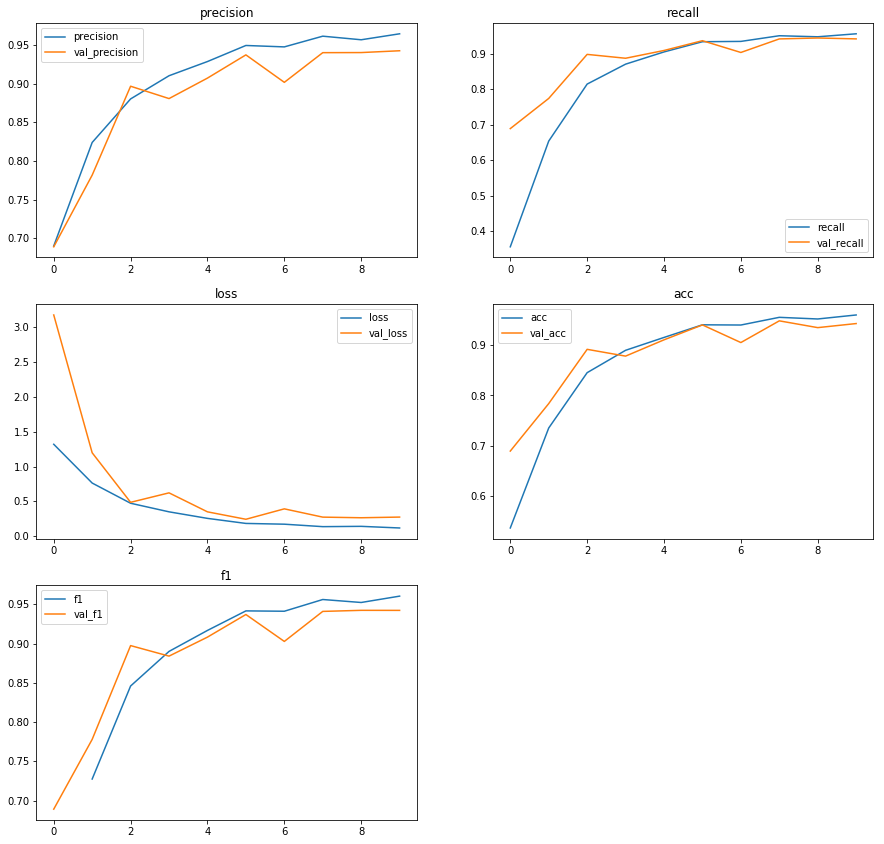

In [9]:
def plot_model(model):
    plots = [i for i in model.model.history.history.keys() if i.find('val_') == -1]
    plt.figure(figsize=(15,25))

    for i, p in enumerate(plots):
        plt.subplot(len(plots), 2, i + 1)
        plt.title(p)
        plt.plot(model.model.history.history[p], label=p)
        plt.plot(model.model.history.history['val_'+p], label='val_'+p)
        plt.legend()

    plt.show()
    
plot_model(model)

In [10]:
from keras.models import load_model

best_model = load_model('models/Model.h5', custom_objects={'recall': recall, 'precision': precision, 'f1': f1})

score, acc, recall, precision, f1 = best_model.evaluate(X_test, y_test, batch_size=64)

idx = len(results) + 1
results.loc[idx] = ['CNN - Transfer Learning', acc, precision, recall, f1]

print('Test score:', score)

results

 64/369 [====>.........................] - ETA: 0s

128/369 [=========>....................] - ETA: 0s

192/369 [==============>...............] - ETA: 0s

256/369 [===================>..........] - ETA: 0s

320/369 [=========================>....] - ETA: 0s

369/369 [==============================] - 0s     


Test score: 0.297192303994


,Model,Accuracy,Precision,Recall,F1
1,CNN - Transfer Learning,0.932249,0.934602,0.929539,0.932047
